# Welcome and have fun learning multiclass classification

#### Metric: **Accuracy**. **[Softvoting](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html)** and weighted average is the objective to score towards target class.

Objective of this notebook used to be a ~simple~ and robust multiclass classifier for future use.

<blockquote style="margin-right:auto; margin-left:auto; padding: 1em; margin:24px;">
    <strong>Fork This Notebook!</strong><br>
Create your own editable copy of this notebook by clicking on the <strong>Copy and Edit</strong> button in the top right corner.
</blockquote>

In [1]:
if '__initialized__' not in locals():
    !pip install scikit-learn -U
    # Intel® Extension for Scikit-learn installation:
    !pip install scikit-learn-intelex
    from sklearnex import patch_sklearn
    patch_sklearn()

# Installation Initialized
__initialized__ = True

     |████████████████████████████████| 24.8 MB 4.3 MB/s            
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.23.2
    Uninstalling scikit-learn-0.23.2:
      Successfully uninstalled scikit-learn-0.23.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.3.post1 requires numpy<1.20,>=1.16.0, but you have numpy 1.20.3 which is incompatible.
pdpbox 0.2.1 requires matplotlib==3.1.1, but you have matplotlib 3.5.1 which is incompatible.
hypertools 0.7.0 requires scikit-learn!=0.22,<0.24,>=0.19.1, but you have scikit-learn 1.0.2 which is incompatible.
featuretools 1.4.0 requires numpy>=1.21.0, but you have numpy 1.20.3 which is incompatible.
     |████████████████████████████████| 69 kB 2.4 MB/s             
     |████████████████████████████████| 22.5 MB 6.5 MB/s            
     |███████████████████████████████

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
from scipy import stats
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, FormatStrFormatter, PercentFormatter
import seaborn as sns

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler, TomekLinks

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, RobustScaler, PowerTransformer, OneHotEncoder
le = LabelEncoder()

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import make_column_transformer, make_column_selector, ColumnTransformer, TransformedTargetRegressor
from sklearn.metrics import accuracy_score, log_loss, confusion_matrix, roc_curve, precision_recall_curve
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV
from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.gaussian_process import GaussianProcessClassifier

from catboost import CatBoostClassifier
from xgboost import XGBClassifier
import lightgbm as lgb

from datetime import datetime
from packaging import version

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import gc
import os
import math
import random

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Fine tuning
Fine tune the system using the hyperparameters and configs below:
* **PRODUCTION** - True: For submission run. False: Fast trial run
* FOLD - 5, 10, 15, 20.
* SAMPLE - Set it to True for full sample run. Max sample per class.
* N_ESTIMATORS - Model hyperparameter

In [3]:
# -----------------------------------------------------------------
# Some parameters to config 
PRODUCTION = True # True: For submission run. False: Fast trial run

# Hyperparameters
FOLDS = 10 if PRODUCTION else 5   # Only 5 or 10.
TREES = 20
N_ESTIMATORS = 1300 if PRODUCTION else 100 # Overfitting vs underfitting https://www.kaggle.com/c/tabular-playground-series-feb-2022/discussion/305463

SAMPLE_WEIGHT = True
AVERAGE_WEIGHTED_FOLD = False
DIST_BOUND = True      # Bound distribution by class accuracy
DIST_THRESHOLD = 0.395 # Distribution bound threshold

RANDOM_STATE = 100
VERBOSE = 0

In [4]:
# If the dataset is too huge for trial. Sampling it for speed run!
SAMPLE = 20139 if PRODUCTION else 20139   # Max Sample size per category. For quick test: y counts [12522, 20139, 20063, 19947, 19958, 19937, 19847, 20030, 19929, 20074, 20076]  # 200000 total rows
VALIDATION_SPLIT = 0.25 # Only used to min dataset for quick test

# Admin
ID = "row_id"            # Id id x X index
INPUT = "../input/tabular-playground-series-feb-2022"
TPU = False           # True: use TPU.
GPU = False           # True: use GPU.
BEST_OR_FOLD = False # True: use Best model, False: use KFOLD softvote
FEATURE_ENGINEERING = True
PSEUDO_LABEL = False
BLEND = False

In [5]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(RANDOM_STATE)

In [6]:
def plot_cm(cm):
    metrics = {
        'accuracy': cm / cm.sum(),
        'recall' : cm / cm.sum(axis = 1 ),
        'precision': cm / cm.sum(axis = 0)
    }
    
    fig, ax = plt.subplots(1,3, tight_layout = True, figsize = (20,6))
    ax = ax.flatten()
#     mask = (np.eye(cm.shape[0]) == 0) * 1
    for idx, (name, matrix) in enumerate(metrics.items()):
        ax[idx].set_title(name)
        sns.heatmap(
            data = matrix,
            cmap = sns.dark_palette("#69d", reverse=True, as_cmap=True),
            cbar = False,
#             mask=mask,
            lw = 0.25,
            annot = True,
            fmt = '.2f',
            ax = ax[idx]
        )
#         for tick in ax[idx].get_xticklabels():
#                 tick.set_rotation(60)
                
    sns.despine()
    
def plot_cm_error(cm):
    mask = (np.eye(cm.shape[0]) != 0) * 1
    fig, ax = plt.subplots(tight_layout=True, figsize=(15,8))
    sns.heatmap(
                data = pd.DataFrame(data=cm, index=le.classes_, columns = le.classes_),
#                 cmap=sns.dark_palette("#69d", reverse=True, as_cmap=True),
                cbar = False,
                lw = 0.25,
                mask = mask,
                annot = True,
                fmt = '.0f',
                ax = ax
            )
    plt.xticks(rotation=45)
    plt.tight_layout()
    sns.despine()

## Reduce Memory usage

In [7]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2

    for col in df.columns:
        col_type = df[col].dtypes

        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()

            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2

    if verbose:
        print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
 
    return df

In [8]:
from pathlib import Path


def load_data():
    # Read data
    data_dir = Path(INPUT)
    try:
        # Read the parquet data.
        df_train = pd.read_parquet('../input/tpsfeb22-soft-voting-baseline/train.parquet').pipe(reduce_mem_usage)
        df_test = pd.read_parquet('../input/tpsfeb22-soft-voting-baseline/test.parquet').pipe(reduce_mem_usage)
    except FileNotFoundError:
        df_train = pd.read_csv(data_dir / "train.csv", index_col=ID).pipe(reduce_mem_usage)
        df_test = pd.read_csv(data_dir / "test.csv", index_col=ID).pipe(reduce_mem_usage)

    # Save the csv file to parquet.
    # I learned parquet from this notebook: https://www.kaggle.com/wti200/one-vs-rest-approach
    df_train.to_parquet('train.parquet')
    df_test.to_parquet('test.parquet')
    column_y = df_train.columns.difference(
        df_test.columns)[0]  # column_y target_col label_col
    return df_train, df_test, column_y

## Data Preprocessing ##

Before we can do any feature engineering, we need to *preprocess* the data to get it in a form suitable for analysis. We'll need to:
- **Load** the data from CSV files
- **Clean** the data to fix any errors or inconsistencies
- **Encode** the statistical data type (numeric, categorical)
- **Impute** any missing values

We'll wrap all these steps up in a function, which will make easy for you to get a fresh dataframe whenever you need. After reading the CSV file, we'll apply three preprocessing steps, `clean`, `encode`, and `impute`, and then create the data splits: one (`df_train`) for training the model, and one (`df_test`) for making the predictions that you'll submit to the competition for scoring on the leaderboard.

In [9]:
%%time
train_data, test_data, TARGET_FEATURE_NAME = load_data()

Mem. usage decreased to 221.25 Mb (0.0% reduction)
Mem. usage decreased to 109.86 Mb (0.0% reduction)
CPU times: user 4.22 s, sys: 879 ms, total: 5.1 s
Wall time: 6.1 s


# Project Genome
The data (both train and test) also contains simulated measurement errors (of varying rates) for many of the samples, which makes the problem more challenging.

In [10]:
def read_sers_genome(files):
    df_sers = [pd.read_csv(file, index_col=0).pipe(reduce_mem_usage) for file in files]
    df = pd.concat(df_sers)
#     df.drop_duplicates(keep='first', inplace=True)
    df = df.rename(columns={"Name": TARGET_FEATURE_NAME})
    
    mutation_map = {'Bacteroides_fragilis_strainBOB25': 'Bacteroides_fragilis',
                'Campylobacter_jejuni_RM1221': 'Campylobacter_jejuni',
                'Enterococcus_hirae_ATCC9790': 'Enterococcus_hirae',
                'Escherichia_coli_O157': 'Escherichia_coli',
                'Escherichia_fergusonii_EFCF056': 'Escherichia_fergusonii',
                'Klebsiella_pneumoniae_Kp52145': 'Klebsiella_pneumoniae',
                'Salmonella_enterica_Newport': 'Salmonella_enterica',
                'Staphylococcus_aureus_MRSA252': 'Staphylococcus_aureus',
                'Streptococcus_pneumoniae_JJA': 'Streptococcus_pneumoniae',
                'Streptococcus_pneumonia': 'Streptococcus_pneumoniae',
                'Streptococcus_pyogenes_MGAS315': 'Streptococcus_pyogenes'}
    df = df.replace({TARGET_FEATURE_NAME: mutation_map})
    
    return df

In [11]:
sers_files = [
                '../input/sers-1-genome-10mer-data/SERS_1_1000000_Testing_Genome_10mer_data.csv',
                '../input/sers-1-genome-10mer-data/SERS_1_100000_Testing_Genome_10mer_data.csv',
                '../input/sers-1-genome-10mer-data/SERS_1_1000_Testing_Genome_10mer_data.csv',
#                 '../input/sers-1-genome-10mer-data/SERS_1_100_Testing_Genome_10mer_data.csv',
#                 '../input/sers-10-genome-10mer-data/SERS_10_1000000_Testing_Genome_10mer_data.csv',
#                 '../input/sers-10-genome-10mer-data/SERS_10_100000_Testing_Genome_10mer_data.csv',
#                 '../input/sers-10-genome-10mer-data/SERS_10_1000_Testing_Genome_10mer_data.csv',
#                 '../input/sers-10-genome-10mer-data/SERS_10_100_Testing_Genome_10mer_data.csv',
#                 '../input/sers-25-genome-10mer-data/SERS_25_1000000_Testing_Genome_10mer_data.csv',
#                 '../input/sers-25-genome-10mer-data/SERS_25_100000_Testing_Genome_10mer_data.csv',
#                 '../input/sers-25-genome-10mer-data/SERS_25_1000_Testing_Genome_10mer_data.csv',
#                 '../input/sers-25-genome-10mer-data/SERS_25_100_Testing_Genome_10mer_data.csv',
#                 '../input/sers-33-genome-10mer-data/SERS_33_1000000_Testing_Genome_10mer_data.csv',
#                 '../input/sers-33-genome-10mer-data/SERS_33_100000_Testing_Genome_10mer_data.csv',
                '../input/sers-33-genome-10mer-data/SERS_33_1000_Testing_Genome_10mer_data.csv',
#                 '../input/sers-33-genome-10mer-data/SERS_33_100_Testing_Genome_10mer_data.csv',
#                 '../input/sers-50-genome-10mer-data/SERS_50_1000000_Testing_Genome_10mer_data.csv',
#                 '../input/sers-50-genome-10mer-data/SERS_50_100000_Testing_Genome_10mer_data.csv',
#                 '../input/sers-50-genome-10mer-data/SERS_50_1000_Testing_Genome_10mer_data.csv',
#                 '../input/sers-50-genome-10mer-data/SERS_50_100_Testing_Genome_10mer_data.csv',
#                 '../input/sers-75-genome-10mer-data/SERS_75_1000000_Testing_Genome_10mer_data.csv',
#                 '../input/sers-75-genome-10mer-data/SERS_75_100000_Testing_Genome_10mer_data.csv',
#                 '../input/sers-75-genome-10mer-data/SERS_75_1000_Testing_Genome_10mer_data.csv',
                '../input/sers-75-genome-10mer-data/SERS_75_100_Testing_Genome_10mer_data.csv',
#                 '../input/sers-90-genome-10mer-data/SERS_90_1000000_Testing_Genome_10mer_data.csv',
#                 '../input/sers-90-genome-10mer-data/SERS_90_100000_Testing_Genome_10mer_data.csv',
                '../input/sers-90-genome-10mer-data/SERS_90_1000_Testing_Genome_10mer_data.csv',
#                 '../input/sers-90-genome-10mer-data/SERS_90_100_Testing_Genome_10mer_data.csv',
#                 '../input/sers-100-genome-10mer-data/SERS_100_1000_Testing_Genome_10mer_data.csv',
#                 '../input/sers-100-genome-10mer-data/SERS_100_100_Testing_Genome_10mer_data.csv',
            ]

df_genome = read_sers_genome(sers_files)

Mem. usage decreased to 33.19 Mb (49.7% reduction)
Mem. usage decreased to 33.19 Mb (49.7% reduction)
Mem. usage decreased to 33.19 Mb (49.7% reduction)
Mem. usage decreased to 22.13 Mb (49.7% reduction)
Mem. usage decreased to 22.13 Mb (49.7% reduction)
Mem. usage decreased to 22.13 Mb (49.7% reduction)


In [12]:
np.unique(df_genome[TARGET_FEATURE_NAME])

array(['Bacteroides_fragilis', 'Campylobacter_jejuni',
       'Enterococcus_hirae', 'Escherichia_coli', 'Escherichia_fergusonii',
       'Klebsiella_pneumoniae', 'Salmonella_enterica',
       'Staphylococcus_aureus', 'Streptococcus_pneumoniae',
       'Streptococcus_pyogenes'], dtype=object)

In [13]:
pd.merge(df_genome, test_data, on=list(test_data.columns), how='inner')

Empty DataFrame
Columns: [A0T0G0C10, A0T0G1C9, A0T0G2C8, A0T0G3C7, A0T0G4C6, A0T0G5C5, A0T0G6C4, A0T0G7C3, A0T0G8C2, A0T0G9C1, A0T0G10C0, A0T1G0C9, A0T1G1C8, A0T1G2C7, A0T1G3C6, A0T1G4C5, A0T1G5C4, A0T1G6C3, A0T1G7C2, A0T1G8C1, A0T1G9C0, A0T2G0C8, A0T2G1C7, A0T2G2C6, A0T2G3C5, A0T2G4C4, A0T2G5C3, A0T2G6C2, A0T2G7C1, A0T2G8C0, A0T3G0C7, A0T3G1C6, A0T3G2C5, A0T3G3C4, A0T3G4C3, A0T3G5C2, A0T3G6C1, A0T3G7C0, A0T4G0C6, A0T4G1C5, A0T4G2C4, A0T4G3C3, A0T4G4C2, A0T4G5C1, A0T4G6C0, A0T5G0C5, A0T5G1C4, A0T5G2C3, A0T5G3C2, A0T5G4C1, A0T5G5C0, A0T6G0C4, A0T6G1C3, A0T6G2C2, A0T6G3C1, A0T6G4C0, A0T7G0C3, A0T7G1C2, A0T7G2C1, A0T7G3C0, A0T8G0C2, A0T8G1C1, A0T8G2C0, A0T9G0C1, A0T9G1C0, A0T10G0C0, A1T0G0C9, A1T0G1C8, A1T0G2C7, A1T0G3C6, A1T0G4C5, A1T0G5C4, A1T0G6C3, A1T0G7C2, A1T0G8C1, A1T0G9C0, A1T1G0C8, A1T1G1C7, A1T1G2C6, A1T1G3C5, A1T1G4C4, A1T1G5C3, A1T1G6C2, A1T1G7C1, A1T1G8C0, A1T2G0C7, A1T2G1C6, A1T2G2C5, A1T2G3C4, A1T2G4C3, A1T2G5C2, A1T2G6C1, A1T2G7C0, A1T3G0C6, A1T3G1C5, A1T3G2C4, A1T3G3C3, A1T3G4C2, A1T3G5C1, A1T3G6C0, ...]
Index: []

[0 rows x 287 columns]

In [14]:
duplicates_train = df_genome.duplicated().sum()
print('Duplicates in train data: {0}'.format(duplicates_train))

Duplicates in train data: 82000


In [15]:
from math import factorial
gcd_df = train_data.copy()
elements = [e for e in gcd_df.columns if e != ID and e != TARGET_FEATURE_NAME]

def bias(w, x, y, z):
    return factorial(10) / (factorial(w) * factorial(x) * factorial(y) * factorial(z) * 4**10)

def bias_of(s):
    w = int(s[1:s.index('T')])
    x = int(s[s.index('T')+1:s.index('G')])
    y = int(s[s.index('G')+1:s.index('C')])
    z = int(s[s.index('C')+1:])
    return factorial(10) / (factorial(w) * factorial(x) * factorial(y) * factorial(z) * 4**10)

def gcd_of_all(df_i):
    gcd = df_i[elements[0]]
    for col in elements[1:]:
        gcd = np.gcd(gcd, df_i[col])
    return gcd



In [16]:
from sklearn.decomposition import PCA, TruncatedSVD
gcd_le = LabelEncoder()
gcd_le.fit(train_data[TARGET_FEATURE_NAME])

def pca_gcd10_full(df, target, gcd=10, title=''):
    """Plot a 2d projection of all points of df with gcd = 10, colored by target"""
    subset = df[df.gcd == gcd]
    pred_subset = gcd_le.transform(target)[df.gcd == gcd]
    # Compute the PCA
    pca3 = TruncatedSVD(n_components=10, random_state=RANDOM_STATE)
    pca3.fit(subset[elements])

    # Transform the data so that the components can be analyzed
    Xt_tr3 = pca3.transform(subset[elements])

    # Plot a scattergram, projected to two PCA components
    d0, d1 = 1, 2
    plt.scatter(Xt_tr3[:,d0], Xt_tr3[:,d1], c=pred_subset, cmap='tab10', s=1)
    plt.title(title)

In [17]:
df_pseudo = pd.read_csv("../input/tpsfeb22-soft-voting-baseline/submission.csv", index_col=ID).pipe(reduce_mem_usage)

Mem. usage decreased to  1.53 Mb (0.0% reduction)


In [18]:
pseudo_df = test_data.copy()
pseudo_df[TARGET_FEATURE_NAME] = df_pseudo[TARGET_FEATURE_NAME]

## Concat

In [19]:
# train_data = pd.concat([train_data,df_genome])

In [20]:
# Check NA
missing_val = train_data.isnull().sum()
print(missing_val[missing_val > 0])

Series([], dtype: int64)


## Duplicate rows check
https://www.kaggle.com/sfktrkl/tps-feb-2022/notebook

In [21]:
# Save original target distribution
target_distribution = train_data[TARGET_FEATURE_NAME].value_counts().sort_index() / len(train_data) * 100

duplicates_train = train_data.duplicated().sum()
print('Duplicates in train data: {0}'.format(duplicates_train))

Duplicates in train data: 76007


## Dropping duplicated rows
https://www.kaggle.com/c/tabular-playground-series-feb-2022/discussion/305364

To compensate for dropping the duplicates, column sample_weight is added to the dataframe.

In [22]:
# train_df = train_data.groupby(list(train_data.columns.values)).size().reset_index(name='sample_weight').copy()
vc = train_data.value_counts()
dedup_train = pd.DataFrame([list(tup) for tup in vc.index.values], columns=train_data.columns)
dedup_train['sample_weight'] = vc.values
train_df = dedup_train
train_df.drop_duplicates(keep='first', inplace=True)
duplicates_train = train_df.duplicated().sum()

print('Train data shape:', train_df.shape)
print('Duplicates in train data: {0}'.format(duplicates_train))
train_df

Train data shape: (123993, 288)
Duplicates in train data: 0


A0T0G0C10  A0T0G1C9  A0T0G2C8  A0T0G3C7  A0T0G4C6  A0T0G5C5  \
0      -9.536743e-07 -0.000010 -0.000043 -0.000114 -0.000200 -0.000240   
1      -9.536743e-07 -0.000010 -0.000043  0.000886 -0.000200  0.000760   
2      -9.536743e-07 -0.000010 -0.000043 -0.000114 -0.000200 -0.000240   
3      -9.536743e-07 -0.000010 -0.000043 -0.000114 -0.000200 -0.000240   
4      -9.536743e-07 -0.000010 -0.000043 -0.000114 -0.000200 -0.000240   
...              ...       ...       ...       ...       ...       ...   
123988 -9.536743e-07 -0.000006  0.000003  0.000059  0.000078  0.000033   
123989 -9.536743e-07 -0.000006  0.000003  0.000059  0.000072  0.000033   
123990 -9.536743e-07 -0.000006  0.000003  0.000059  0.000063  0.000023   
123991 -9.536743e-07 -0.000006  0.000003  0.000058  0.000074  0.000041   
123992 -9.536743e-07 -0.000005  0.000014  0.000241  0.000480  0.000544   

        A0T0G6C4  A0T0G7C3      A0T0G8C2  A0T0G9C1  ...  A8T0G2C0  A8T1G0C1  \
0      -0.000200 -0.000114 -4.291534e-05 -0.000010  ... -0.000043 -0.000086   
1      -0.000200  0.000886 -4.291534e-05 -0.000010  ... -0.000043 -0.000086   
2      -0.000200 -0.000114 -4.291534e-05 -0.000010  ... -0.000043 -0.000086   
3      -0.000200 -0.000114 -4.291534e-05 -0.000010  ... -0.000043 -0.000086   
4      -0.000200 -0.000114 -4.291534e-05 -0.000010  ...  0.000957  0.001914   
...          ...       ...           ...       ...  ...       ...       ...   
123988  0.000051  0.000049 -4.915344e-06 -0.000007  ...  0.000051  0.000117   
123989  0.000034  0.000050 -5.915344e-06 -0.000008  ...  0.000067  0.000140   
123990  0.000036  0.000041  8.465576e-08 -0.000008  ...  0.000042  0.000124   
123991  0.000070  0.000051 -5.915344e-06 -0.000008  ...  0.000054  0.000141   
123992  0.000434  0.000213 -9.153442e-07 -0.000007  ...  0.000094  0.000197   

        A8T1G1C0  A8T2G0C0  A9T0G0C1  A9T0G1C0  A9T1G0C0     A10T0G0C0  \
0      -0.000086 -0.000043 -0.000010 -0.000010 -0.000010 -9.536743e-07   
1      -0.000086 -0.000043 -0.000010 -0.000010  0.000990 -9.536743e-07   
2       0.000914  0.002957 -0.000010 -0.000010 -0.000010 -9.536743e-07   
3       0.009914 -0.000043 -0.000010 -0.000010 -0.000010 -9.536743e-07   
4       0.000914 -0.000043 -0.000010 -0.000010 -0.000010 -9.536743e-07   
...          ...       ...       ...       ...       ...           ...   
123988  0.000135  0.000102  0.000012  0.000012  0.000032  4.632568e-08   
123989  0.000123  0.000097  0.000013  0.000011  0.000030  4.632568e-08   
123990  0.000130  0.000088  0.000008  0.000015  0.000026  4.632568e-08   
123991  0.000130  0.000103  0.000011  0.000012  0.000024  4.632568e-08   
123992  0.000233  0.000151  0.000023  0.000015  0.000046 -9.536743e-07   

                       target  sample_weight  
0            Escherichia_coli             18  
1         Salmonella_enterica             17  
2       Staphylococcus_aureus             17  
3        Bacteroides_fragilis             16  
4        Campylobacter_jejuni             16  
...                       ...            ...  
123988       Escherichia_coli              1  
123989       Escherichia_coli              1  
123990       Escherichia_coli              1  
123991       Escherichia_coli              1  
123992    Salmonella_enterica              1  

[123993 rows x 288 columns]

In [23]:
gcd_df = train_df.copy()
train_i = pd.DataFrame({col: ((gcd_df[col] + bias_of(col)) * 1000000).round().astype(int) for col in elements})
gcd_df['gcd'] = gcd_of_all(train_i)
i_genome = pd.DataFrame({col: ((df_genome[col] + bias_of(col)) * 1000000).round().astype(int) for col in elements})
df_genome['gcd'] = gcd_of_all(i_genome)
i_pseudo = pd.DataFrame({col: ((pseudo_df[col] + bias_of(col)) * 1000000).round().astype(int) for col in elements})
pseudo_df['gcd'] = gcd_of_all(i_pseudo)

np.unique(gcd_df['gcd'], return_counts=True)

(array([    1,    10,  1000, 10000]), array([46854, 46908, 15097, 15134]))

In [24]:
np.unique(pseudo_df['gcd'], return_counts=True)

(array([    1,    10,  1000, 10000]), array([25208, 24951, 24930, 24911]))

In [25]:
np.unique(gcd_df['sample_weight'], return_counts=True)

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18]),
 array([92582, 13213,  6785,  4894,  2896,  1565,   879,   481,   302,
          157,   109,    53,    40,    19,    11,     4,     2,     1]))

In [26]:
vc = pseudo_df.value_counts()
dedup_train = pd.DataFrame([list(tup) for tup in vc.index.values], columns=pseudo_df.columns)
dedup_train['sample_weight'] = vc.values

In [27]:
np.unique(dedup_train['sample_weight'], return_counts=True)

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 array([57464,  9162,  3923,  1632,   623,   236,   102,    49,    23,
            6,     1]))

In [28]:
np.unique(df_genome['gcd'], return_counts=True)

(array([    1,    10,  1000, 10000]), array([30000, 30000, 70000, 20000]))

In [29]:
vc = df_genome.value_counts()
dedup_train = pd.DataFrame([list(tup) for tup in vc.index.values], columns=df_genome.columns)
dedup_train['sample_weight'] = vc.values

In [30]:
np.unique(dedup_train['sample_weight'], return_counts=True)

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 29]),
 array([60003,    15,    57,   115,   251,   441,   488,   643,   846,
          887,   803,   772,   589,   502,   424,   312,   271,   162,
          137,    90,    68,    47,    30,    17,    14,    13,     2,
            1]))

# gcd=10000

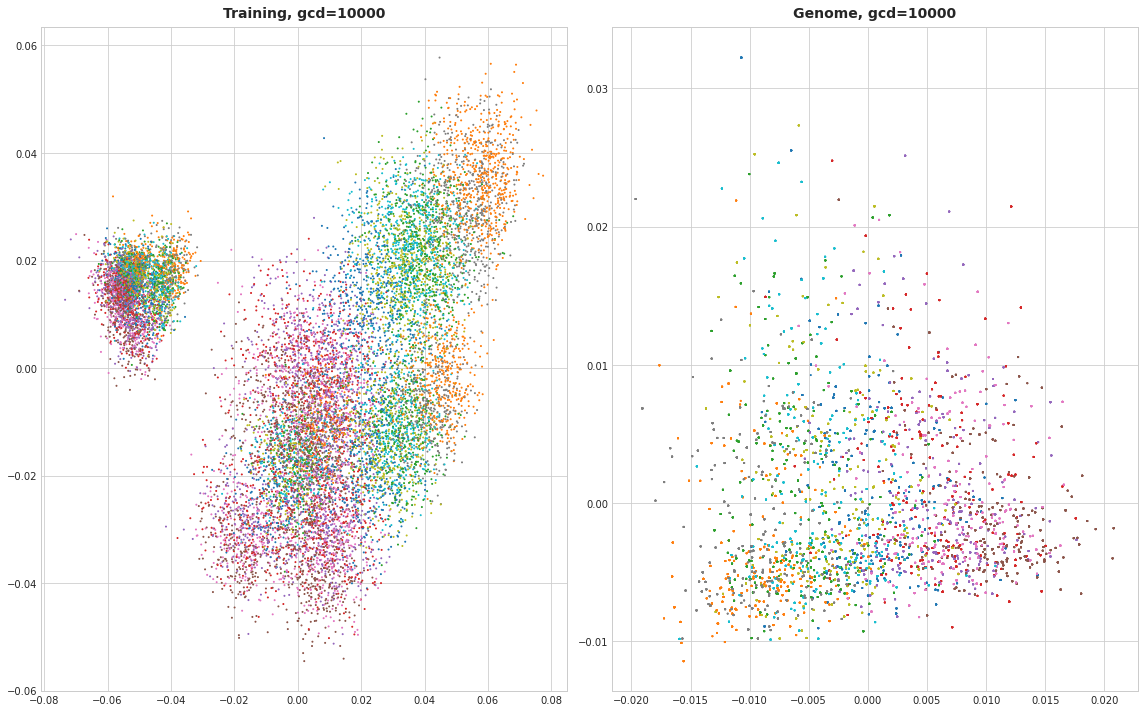

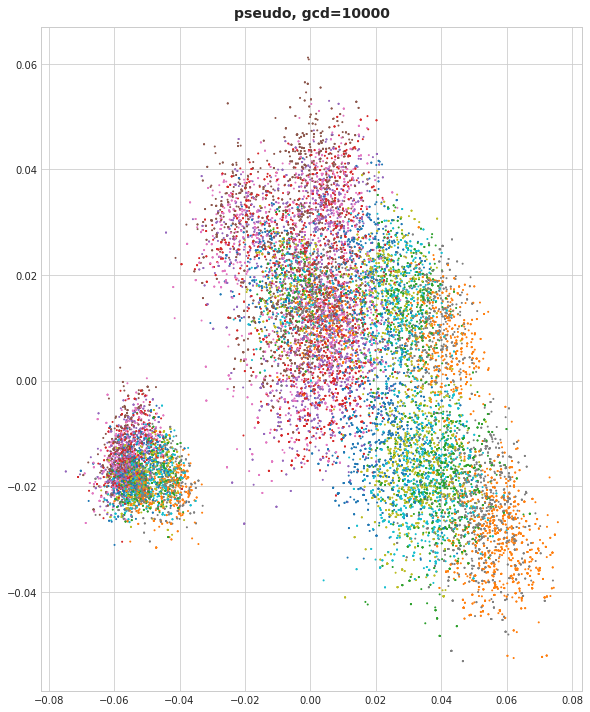

In [31]:
plt.figure(figsize=(16,10))
plt.subplot(1, 2, 1)
gcd=10000
pca_gcd10_full(gcd_df, gcd_df[TARGET_FEATURE_NAME], gcd=gcd, title=f'Training, gcd={gcd}')
plt.subplot(1, 2, 2)
pca_gcd10_full(df_genome, df_genome[TARGET_FEATURE_NAME], gcd=gcd, title=f'Genome, gcd={gcd}')
plt.show()
plt.figure(figsize=(16,10))
plt.subplot(1, 2, 1)
pca_gcd10_full(pseudo_df, pseudo_df[TARGET_FEATURE_NAME], gcd=gcd, title=f'pseudo, gcd={gcd}')
plt.show()

# gcd=1000

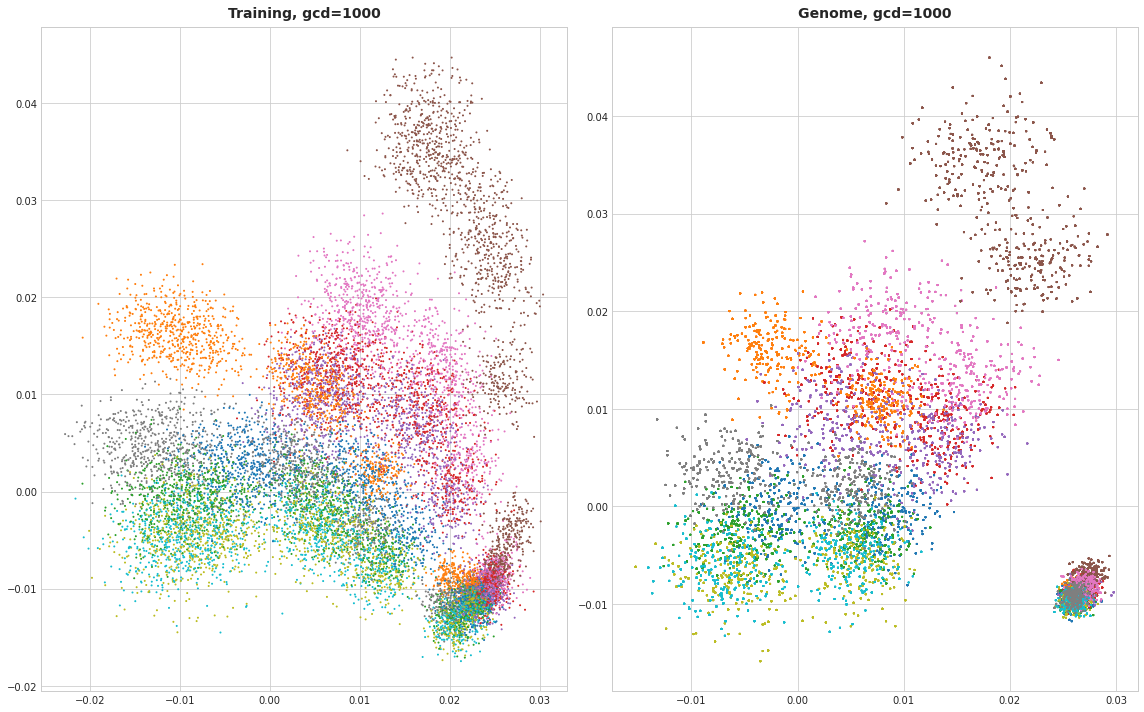

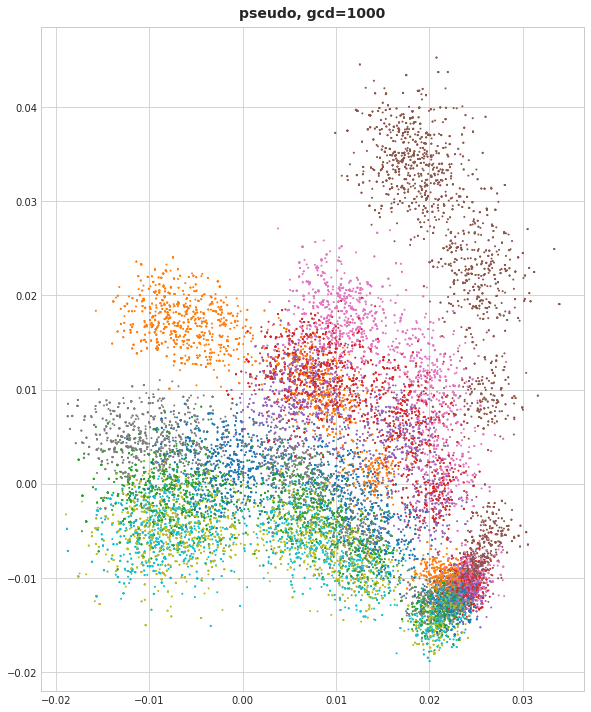

In [32]:
plt.figure(figsize=(16,10))
plt.subplot(1, 2, 1)
gcd=1000
pca_gcd10_full(gcd_df, gcd_df[TARGET_FEATURE_NAME], gcd=gcd, title=f'Training, gcd={gcd}')
plt.subplot(1, 2, 2)
pca_gcd10_full(df_genome, df_genome[TARGET_FEATURE_NAME], gcd=gcd, title=f'Genome, gcd={gcd}')
plt.show()
plt.figure(figsize=(16,10))
plt.subplot(1, 2, 1)
pca_gcd10_full(pseudo_df, pseudo_df[TARGET_FEATURE_NAME], gcd=gcd, title=f'pseudo, gcd={gcd}')
plt.show()

In [33]:
df_coli1000 = gcd_df.iloc[np.where((gcd_df[TARGET_FEATURE_NAME]=='Escherichia_coli')&(gcd_df['gcd']==1000))]
df_coli_genome1000 = df_genome.iloc[np.where((df_genome[TARGET_FEATURE_NAME]=='Escherichia_coli')&(df_genome['gcd']==1000))]
vc = df_coli_genome1000.value_counts()
df_coli_genome1000 = pd.DataFrame([list(tup) for tup in vc.index.values], columns=df_coli_genome1000.columns)
df_coli_genome1000['sample_weight'] = vc.values

In [34]:
df_coli_genome1000

A0T0G0C10  A0T0G1C9  A0T0G2C8  A0T0G3C7  A0T0G4C6  A0T0G5C5  A0T0G6C4  \
0   -9.536743e-07  -0.00001 -0.000043 -0.000114   -0.0002  -0.00024   -0.0002   
1   -9.536743e-07  -0.00001 -0.000043 -0.000114   -0.0002  -0.00024   -0.0002   
2   -9.536743e-07  -0.00001 -0.000043 -0.000114   -0.0002  -0.00024    0.0008   
3   -9.536743e-07  -0.00001 -0.000043 -0.000114    0.0008  -0.00024   -0.0002   
4   -9.536743e-07  -0.00001 -0.000043 -0.000114   -0.0002  -0.00024   -0.0002   
..            ...       ...       ...       ...       ...       ...       ...   
595 -9.536743e-07  -0.00001 -0.000043 -0.000114   -0.0002  -0.00024   -0.0002   
596 -9.536743e-07  -0.00001 -0.000043 -0.000114   -0.0002  -0.00024   -0.0002   
597 -9.536743e-07  -0.00001 -0.000043 -0.000114   -0.0002  -0.00024   -0.0002   
598 -9.536743e-07  -0.00001 -0.000043 -0.000114   -0.0002  -0.00024   -0.0002   
599 -9.536743e-07  -0.00001 -0.000043 -0.000114   -0.0002  -0.00024   -0.0002   

     A0T0G7C3  A0T0G8C2  A0T0G9C1  ...  A8T1G0C1  A8T1G1C0  A8T2G0C0  \
0    0.000886 -0.000043  -0.00001  ...  0.000914 -0.000086  0.000957   
1   -0.000114 -0.000043  -0.00001  ... -0.000086  0.000914 -0.000043   
2   -0.000114 -0.000043  -0.00001  ... -0.000086  0.001914 -0.000043   
3   -0.000114 -0.000043  -0.00001  ...  0.000914  0.000914 -0.000043   
4   -0.000114 -0.000043  -0.00001  ... -0.000086 -0.000086 -0.000043   
..        ...       ...       ...  ...       ...       ...       ...   
595 -0.000114 -0.000043  -0.00001  ... -0.000086 -0.000086 -0.000043   
596 -0.000114 -0.000043  -0.00001  ... -0.000086 -0.000086 -0.000043   
597 -0.000114 -0.000043  -0.00001  ... -0.000086 -0.000086 -0.000043   
598 -0.000114 -0.000043  -0.00001  ... -0.000086 -0.000086 -0.000043   
599 -0.000114 -0.000043  -0.00001  ... -0.000086 -0.000086 -0.000043   

     A9T0G0C1  A9T0G1C0  A9T1G0C0     A10T0G0C0            target   gcd  \
0    -0.00001  -0.00001  -0.00001 -9.536743e-07  Escherichia_coli  1000   
1    -0.00001  -0.00001  -0.00001 -9.536743e-07  Escherichia_coli  1000   
2    -0.00001  -0.00001  -0.00001 -9.536743e-07  Escherichia_coli  1000   
3     0.00099  -0.00001  -0.00001 -9.536743e-07  Escherichia_coli  1000   
4    -0.00001  -0.00001  -0.00001 -9.536743e-07  Escherichia_coli  1000   
..        ...       ...       ...           ...               ...   ...   
595  -0.00001  -0.00001  -0.00001 -9.536743e-07  Escherichia_coli  1000   
596  -0.00001  -0.00001  -0.00001 -9.536743e-07  Escherichia_coli  1000   
597  -0.00001  -0.00001  -0.00001 -9.536743e-07  Escherichia_coli  1000   
598  -0.00001  -0.00001  -0.00001 -9.536743e-07  Escherichia_coli  1000   
599  -0.00001  -0.00001  -0.00001 -9.536743e-07  Escherichia_coli  1000   

     sample_weight  
0               25  
1               25  
2               25  
3               24  
4               24  
..             ...  
595              3  
596              3  
597              3  
598              3  
599              3  

[600 rows x 289 columns]

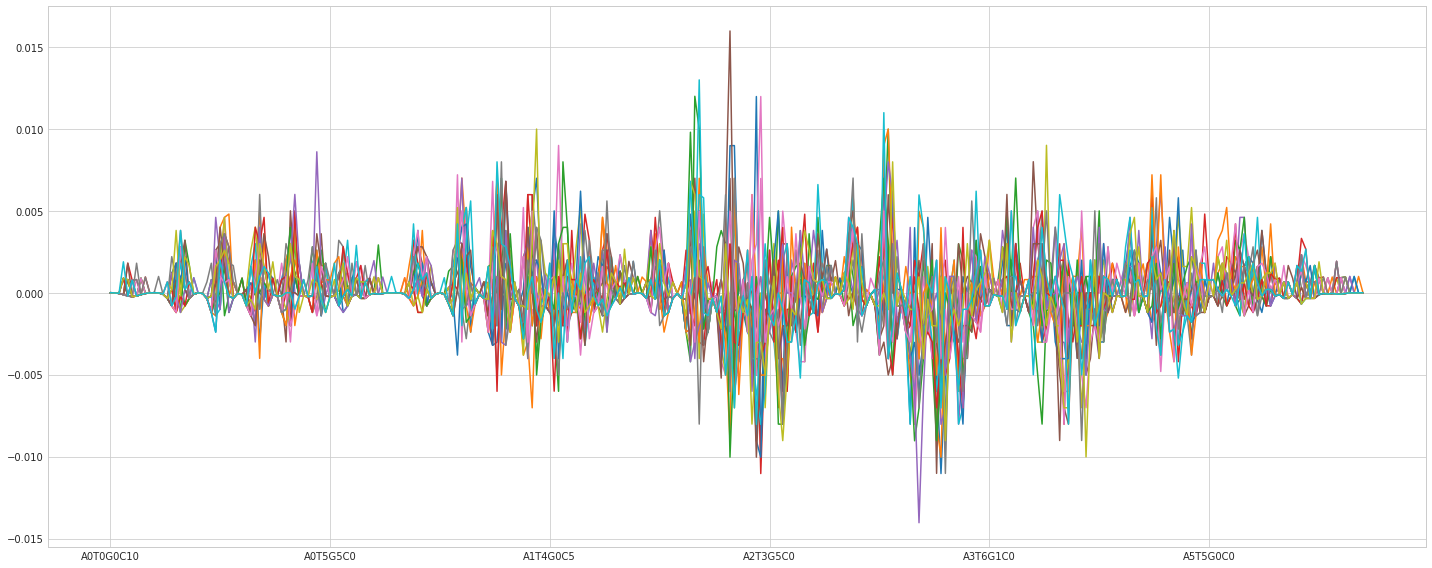

In [35]:
for i in range(0,20):
    df_coli1000.iloc[i][:-3].plot(kind='line',figsize=(20,8))
plt.show()

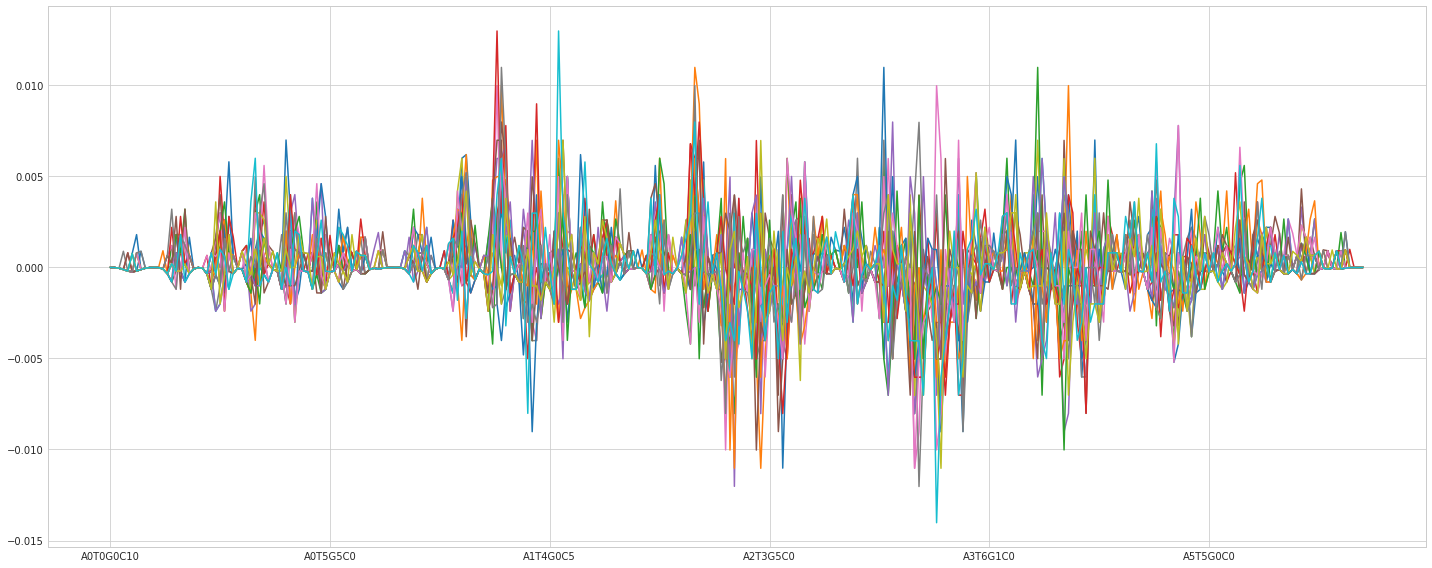

In [36]:
for i in range(0,20):
    df_coli_genome1000.iloc[i][:-3].plot(kind='line',figsize=(20,8))
plt.show()

In [37]:
df_coli10000 = gcd_df.iloc[np.where((gcd_df[TARGET_FEATURE_NAME]=='Escherichia_coli')&(gcd_df['gcd']==10000))]
df_coli_genome10000 = df_genome.iloc[np.where((df_genome[TARGET_FEATURE_NAME]=='Escherichia_coli')&(df_genome['gcd']==10000))]
vc = df_coli_genome10000.value_counts()
df_coli_genome10000 = pd.DataFrame([list(tup) for tup in vc.index.values], columns=df_coli_genome10000.columns)
df_coli_genome10000['sample_weight'] = vc.values

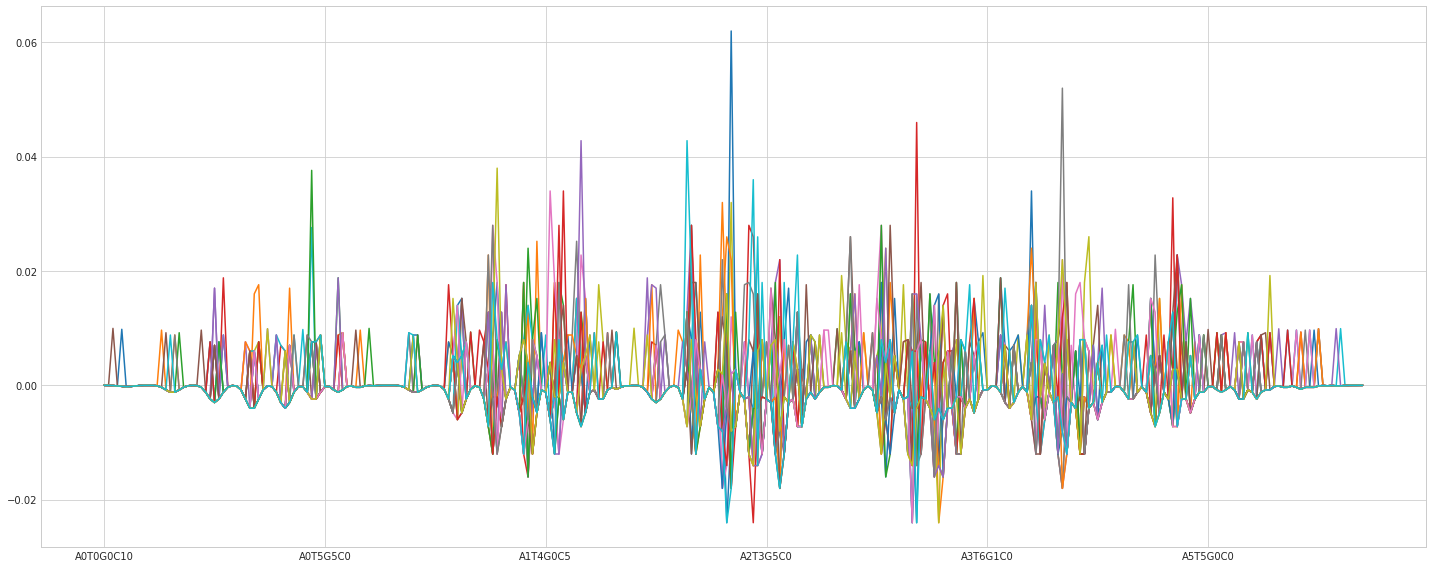

In [38]:
for i in range(0,20):
    df_coli10000.iloc[i][:-3].plot(kind='line',figsize=(20,8))
plt.show()

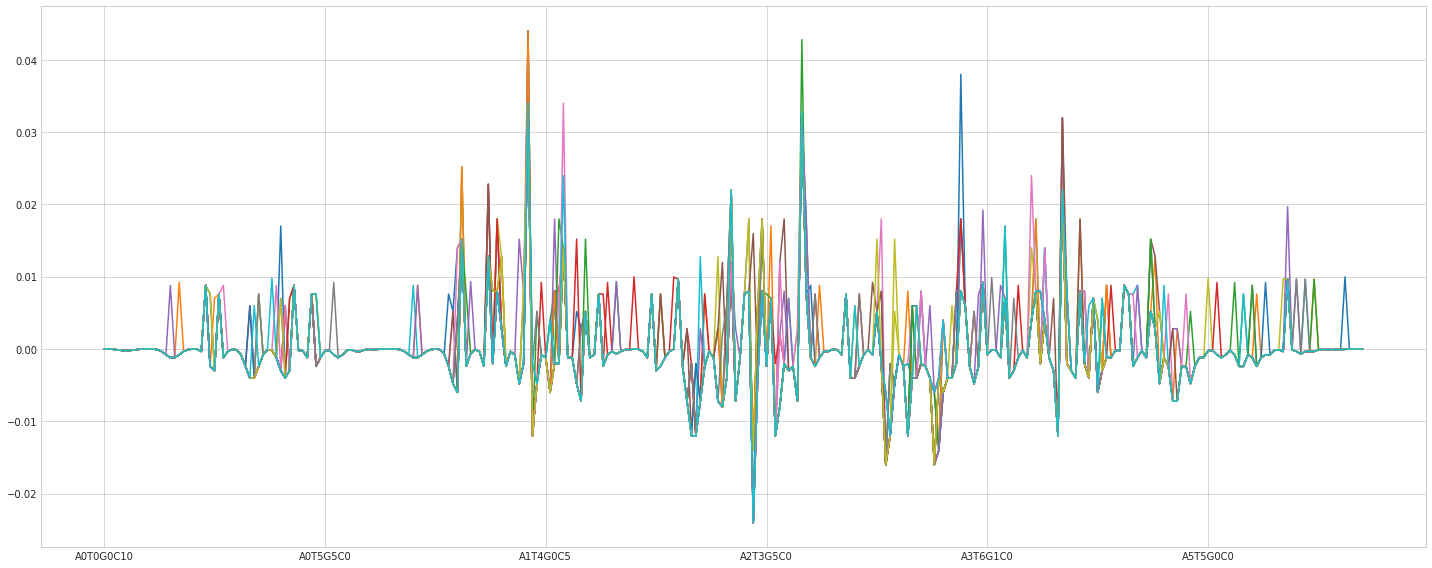

In [39]:
for i in range(0,20):
    df_coli_genome10000.iloc[-i][:-3].plot(kind='line',figsize=(20,8))
plt.show()

In [40]:
df_coli10 = gcd_df.iloc[np.where((gcd_df[TARGET_FEATURE_NAME]=='Escherichia_coli')&(gcd_df['gcd']==10))]
df_coli_genome10 = df_genome.iloc[np.where((df_genome[TARGET_FEATURE_NAME]=='Escherichia_coli')&(df_genome['gcd']==10))]
vc = df_coli_genome10.value_counts()
df_coli_genome10 = pd.DataFrame([list(tup) for tup in vc.index.values], columns=df_coli_genome10.columns)
df_coli_genome10['sample_weight'] = vc.values

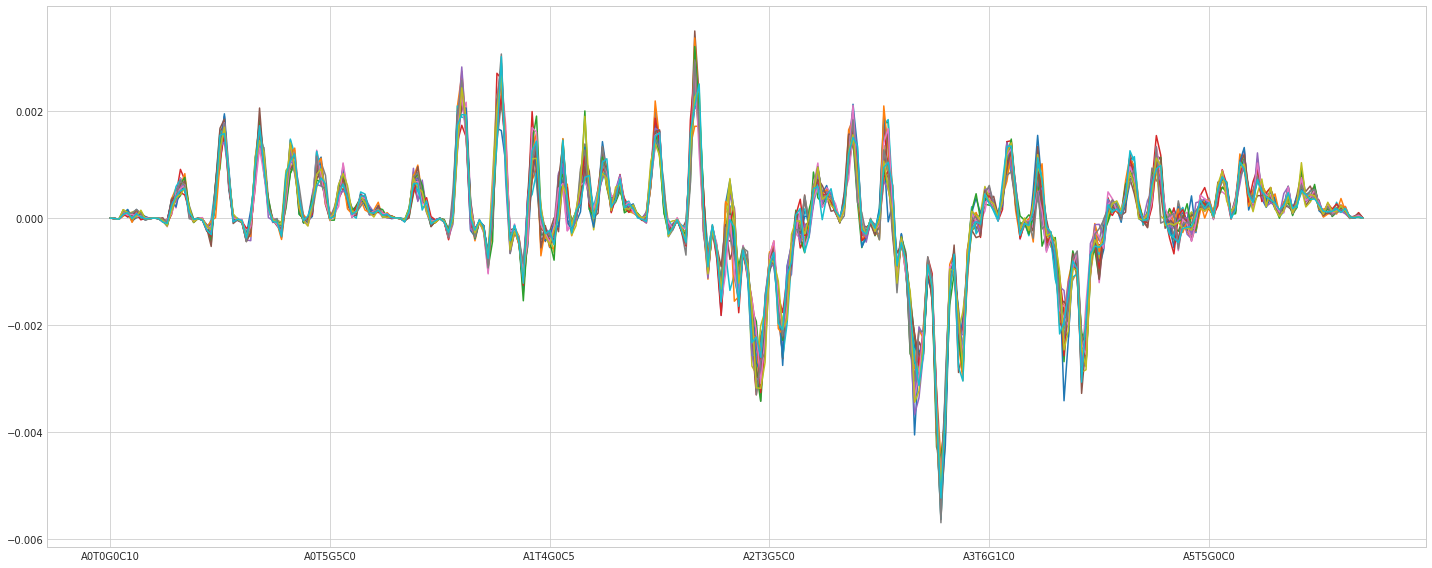

In [41]:
for i in range(0,20):
    df_coli10.iloc[i][:-3].plot(kind='line',figsize=(20,8))
plt.show()

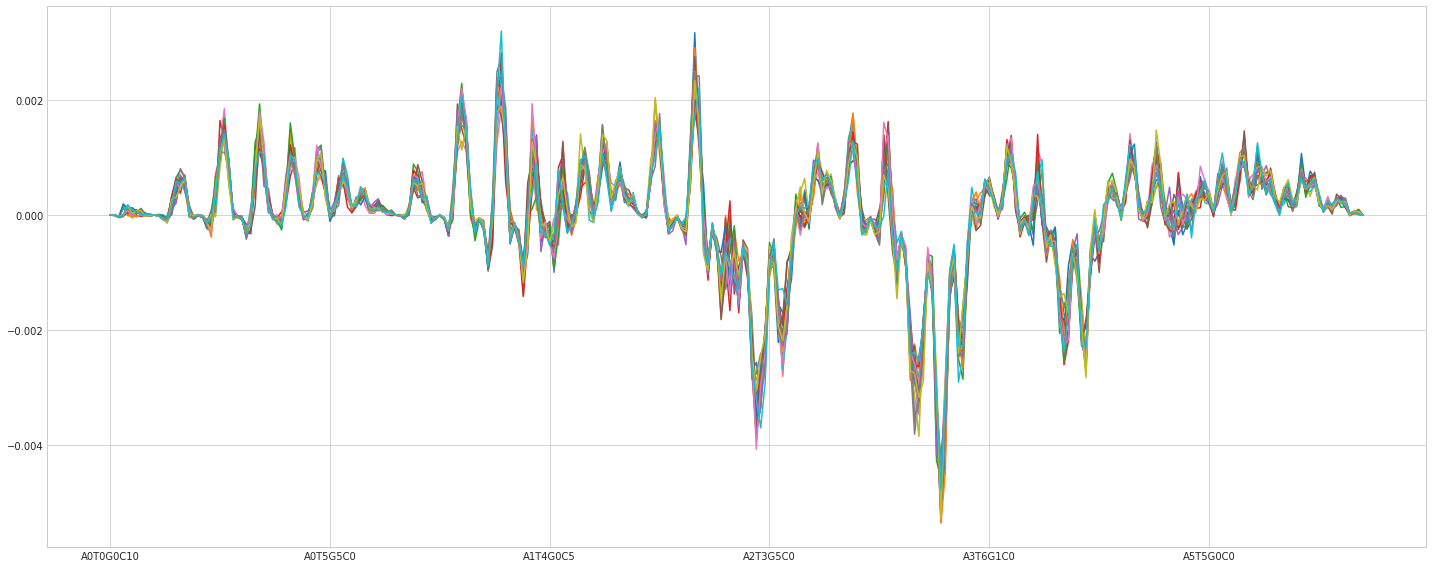

In [42]:
for i in range(0,20):
    df_coli_genome10.iloc[i][:-3].plot(kind='line',figsize=(20,8))
plt.show()

In [43]:
df_coli1 = gcd_df.iloc[np.where((gcd_df[TARGET_FEATURE_NAME]=='Escherichia_coli')&(gcd_df['gcd']==1))]
df_coli_genome1 = df_genome.iloc[np.where((df_genome[TARGET_FEATURE_NAME]=='Escherichia_coli')&(df_genome['gcd']==1))]
vc = df_coli_genome1.value_counts()
df_coli_genome1 = pd.DataFrame([list(tup) for tup in vc.index.values], columns=df_coli_genome1.columns)
df_coli_genome1['sample_weight'] = vc.values

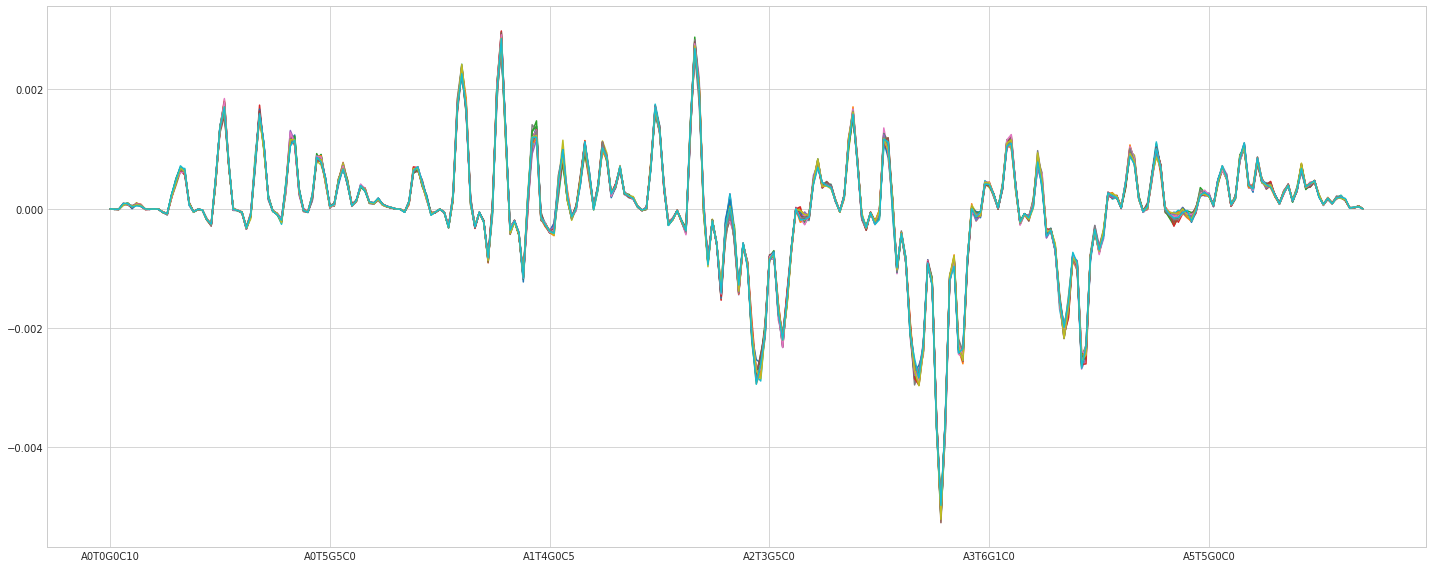

In [44]:
for i in range(0,20):
    df_coli1.iloc[i][:-3].plot(kind='line',figsize=(20,8))
plt.show()

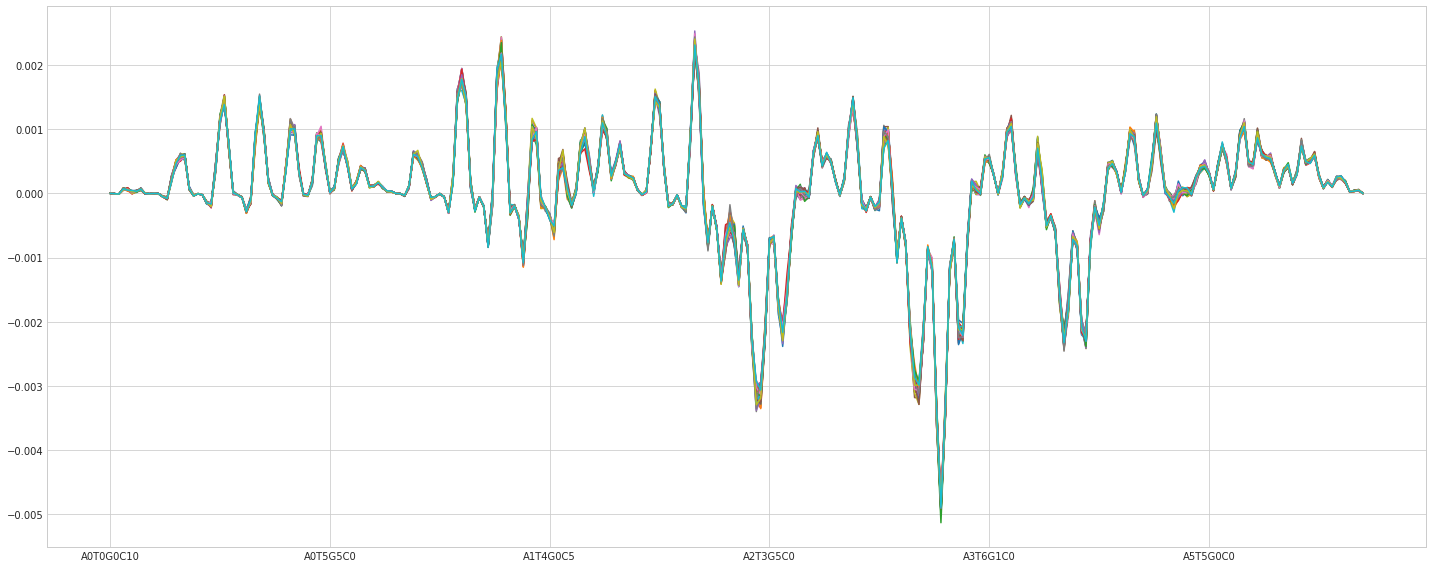

In [45]:
for i in range(0,50):
    df_coli_genome1.iloc[i][:-3].plot(kind='line',figsize=(20,8))
plt.show()

## X y Training dataset and Testing dataset

In [46]:
del duplicates_train
del vc
del dedup_train
# del df_genome
del df_pseudo

del df_coli1
del df_coli_genome1
del df_coli10
del df_coli_genome10
del df_coli1000
del df_coli_genome1000
del df_coli10000
del df_coli_genome10000

# del train_data
# del train_df
gc.collect()

54611

# Train Model and Create Submissions #

Once you're satisfied with everything, it's time to create your final predictions! This cell will:
- use the best trained model to make predictions from the test set
- save the predictions to a CSV file

$Softmax: \sigma(z_i) = \frac{e^{z_{i}}}{\sum_{j=1}^K e^{z_{j}}} \ \ \ for\ i=1,2,\dots,K$

K - number of classes

$z_i$ - is a vector containing the scores of each class for the instance z.

$\sigma(z_i)$ - is the estimated probability that the instance z belongs to class K, given the scores of each class for that instance.

$Relu(z) = max(0, z)$

Binary Cross Entropy: $-{(y\log(p) + (1 - y)\log(1 - p))}$

For multiclass classification, we calculate a separate loss for each class label per observation and sum the result.

$-\sum_{c=1}^My_{o,c}\log(p_{o,c})$


    M - number of classes

    log - the natural log

    y - binary indicator (0 or 1) if class label c is the correct classification for observation o

    p - predicted probability observation o is of class c



## Create Models

## Stacker pipeline with CV
Decision tree does not require feature scaling.

**sklearn.linear_model.LogisticRegressionCV**

class_weight: dict or ‘balanced’, default=None

    Weights associated with classes in the form {class_label: weight}. If not given, all classes are supposed to have weight one.

    The “balanced” mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data as n_samples / (n_classes * np.bincount(y)).

    Note that these weights will be multiplied with sample_weight (passed through the fit method) if sample_weight is specified.

# Train model

Sample weight distribution

## Cross-validation
While V-fold cross-validation does have inflated variance, its bias is fairly low when V is 10 or more.

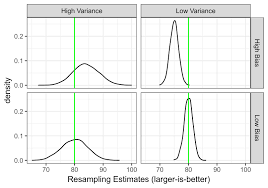

Four possible variance/bias cases are represented. We will that the model metric being measured here is better when the value is large and that the true value is represented by the green vertical line. The upper right right panel demonstrates a pessimistic bias since the values tend to be smaller than the true value while the panel below in the lower right shows a resampling scheme that has relatively low variance and the center of its distribution is on target with the true value. 

## Test prediction

## Cross Validation Score

But instead of just looking at the mean accuracy across the 10 cross-validation folds, let's plot all 10 scores for each model, along with a box plot highlighting the lower and upper quartiles, and "whiskers" showing the extent of the scores. Note that the `boxplot()` function detects outliers (called "fliers") and does not include them within the whiskers. Specifically, if the lower quartile is $Q_1$ and the upper quartile is $Q_3$, then the interquartile range $IQR = Q_3 - Q_1$ (this is the box's height), and any score lower than $Q_1 - 1.5 \times IQR$ is a flier, and so is any score greater than $Q3 + 1.5 \times IQR$.

In [47]:
vc = df_genome.value_counts()
df_genome = pd.DataFrame([list(tup) for tup in vc.index.values], columns=df_genome.columns)
df_genome['sample_weight'] = vc.values
vc = pseudo_df.value_counts()
pseudo_df = pd.DataFrame([list(tup) for tup in vc.index.values], columns=pseudo_df.columns)
pseudo_df['sample_weight'] = vc.values

In [48]:
def get_Xy(df, gcd=1000):
    df = df[df.gcd == gcd]
    X = df.drop(columns=[TARGET_FEATURE_NAME, 'sample_weight', 'gcd'])
    y = df[[TARGET_FEATURE_NAME]]
    weights = df['sample_weight']
    return X, y, weights

In [49]:
def evaluate_model(X_train, y_train, X_test, y_test, sample_weight_train, sample_weight_valid):
    # Build model
    eclf = ExtraTreesClassifier(
        n_estimators=N_ESTIMATORS,
        n_jobs=-1,
        random_state=RANDOM_STATE,
        verbose=VERBOSE
    )
#     eclf = GaussianProcessClassifier()

    # Train
#     eclf = eclf.fit(X=X_train, y=y_train, sample_weight=sample_weight_train)
    eclf = eclf.fit(X=X_train, y=y_train)
    preds_test=[]
    # Predict test dataset
    preds_test.append(eclf.predict_proba(X_submission))
    # resets
    preds_valid_f = {}
    index_valid = X_test.index.tolist()
    preds_valid = eclf.predict_proba(X_test)
    preds_valid_f.update(dict(zip(index_valid, le.inverse_transform(np.argmax(preds_valid, axis=1)))))
    print(accuracy_score(y_test, np.argmax(preds_valid, axis=1), sample_weight=sample_weight_valid))
    print(log_loss(y_test, preds_valid, sample_weight=sample_weight_valid))
    return preds_valid_f, preds_test

# Test gcd=1000

In [50]:
X_train_df, X_test_df, _, _ = train_test_split(gcd_df, gcd_df[TARGET_FEATURE_NAME], stratify=gcd_df[TARGET_FEATURE_NAME], test_size=VALIDATION_SPLIT, random_state=RANDOM_STATE)

X_train, y_train, sample_weight_train = get_Xy(X_train_df) #pseudo_df #gcd_df #df_genome
X_test, y_test, sample_weight_valid = get_Xy(X_test_df) #pseudo_df #gcd_df #df_genome

X_submission = test_data.loc[:,X_train.columns]

# Prepare for multiclass classification
y_train = le.fit_transform(y_train[TARGET_FEATURE_NAME]) # y to categorical
y_test = le.transform(y_test[TARGET_FEATURE_NAME]) # y to categorical

gc.collect()

63

In [51]:
np.unique(X_train_df['gcd'], return_counts=True)

(array([    1,    10,  1000, 10000]), array([35160, 35223, 11277, 11334]))

In [52]:
np.unique(sample_weight_train, return_counts=True)

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17]),
 array([1839, 2657, 2479, 1878, 1086,  579,  333,  181,  103,   54,   35,
          24,   15,    8,    3,    1,    2]))

In [53]:
%%time

preds_valid_f, preds_test = evaluate_model(X_train, y_train, X_test, y_test, sample_weight_train, sample_weight_valid)

0.9273427067787291
0.6432562729635619
CPU times: user 2min 9s, sys: 1.3 s, total: 2min 10s
Wall time: 34.3 s


## Confusion matrix

$Accuracy = \frac{TP+TN}{TP+TN+FP+FN}$

$Precision = \frac{TP}{TP+FP}$

$Recall = \frac{TP}{TP+FN}$

$F1 = \frac{2*Precision*Recall}{Precision+Recall} = \frac{2*TP}{2*TP+FP+FN}$

TODO: The gap is too huge. The network is overconfidence over some error.

In [54]:
len(y_test)

3820

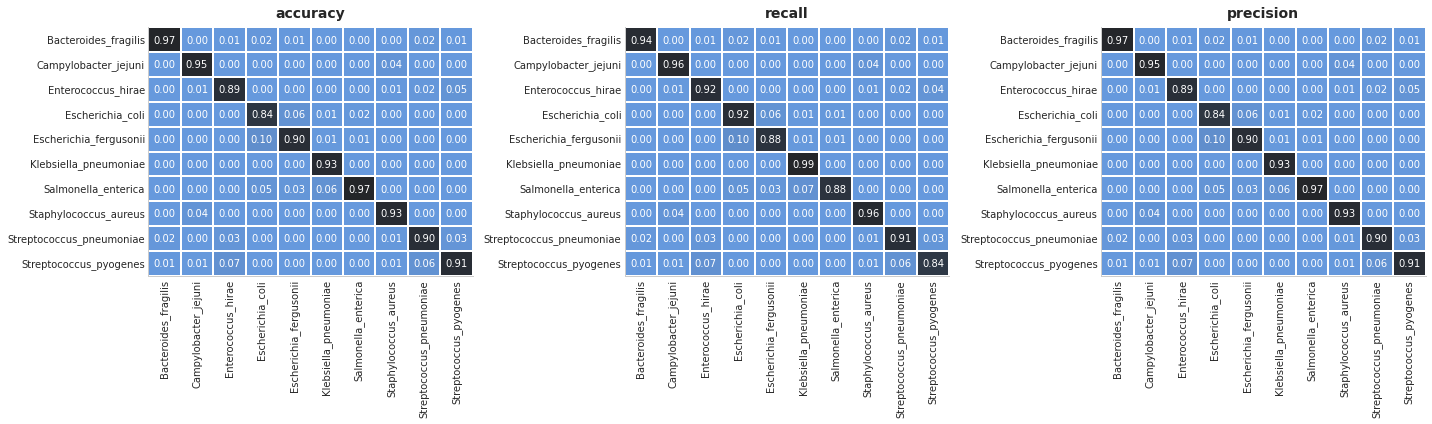

In [55]:
oof_y_hat = []
for key, value in preds_valid_f.items():
    oof_y_hat.append(value)
# create confusion matrix, calculate accuracy,recall & precision
cm = pd.DataFrame(data = confusion_matrix(le.inverse_transform(y_test), oof_y_hat, labels = le.classes_), index = le.classes_, columns = le.classes_)
plot_cm(cm)

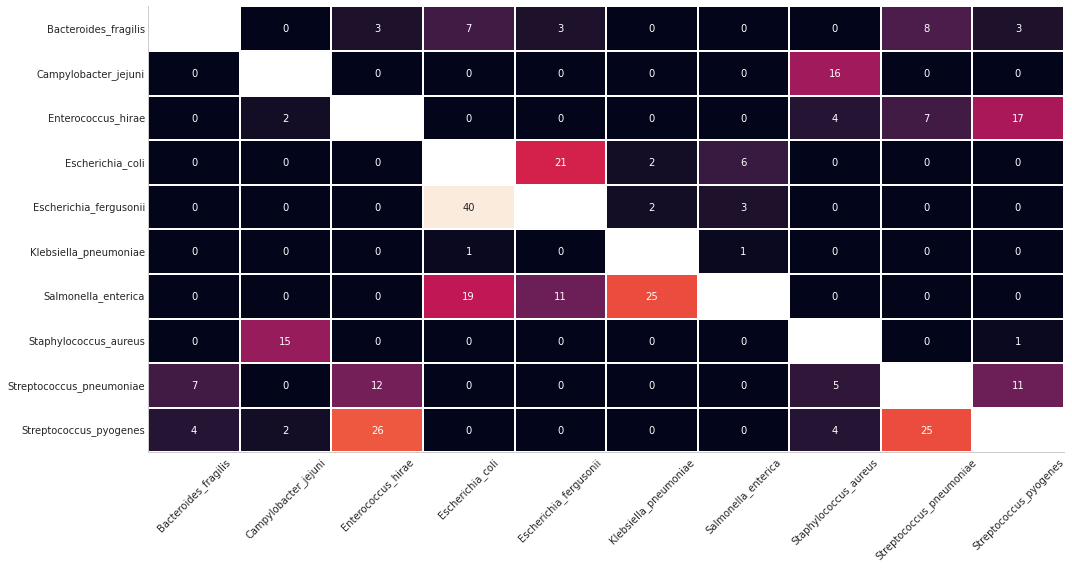

In [56]:
plot_cm_error(confusion_matrix(le.inverse_transform(y_test), oof_y_hat, labels = le.classes_))

# Genome

# gcd=1000

In [57]:
train = pd.concat([X_train_df,df_genome])
X_train, y_train, sample_weight_train = get_Xy(train) #pseudo_df #gcd_df #df_genome
# X_test, y_test, sample_weight_valid = get_Xy(X_test_df) #pseudo_df #gcd_df #df_genome

# Prepare for multiclass classification
y_train = le.transform(y_train[TARGET_FEATURE_NAME]) # y to categorical
# y_test = le.transform(y_test[TARGET_FEATURE_NAME]) # y to categorical

gc.collect()

35929

In [58]:
np.unique(sample_weight_train, return_counts=True)

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 29]),
 array([1841, 2667, 2517, 1955, 1255,  877,  664,  621,  691,  683,  612,
         589,  471,  413,  357,  272,  243,  148,  129,   86,   65,   45,
          29,   17,   14,   13,    2,    1]))

In [59]:
%%time

preds_valid_f, preds_test = evaluate_model(X_train, y_train, X_test, y_test, sample_weight_train, sample_weight_valid)

0.9311130311837248
0.6559032729642245
CPU times: user 3min 13s, sys: 2.35 s, total: 3min 15s
Wall time: 50.7 s


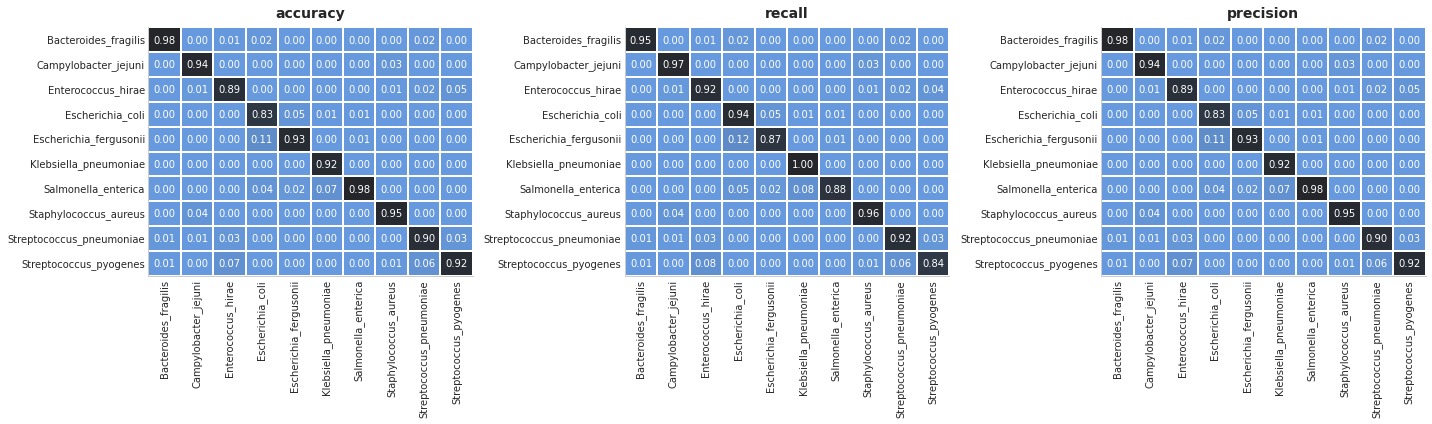

In [60]:
oof_y_hat = []
for key, value in preds_valid_f.items():
    oof_y_hat.append(value)
# create confusion matrix, calculate accuracy,recall & precision
cm = pd.DataFrame(data = confusion_matrix(le.inverse_transform(y_test), oof_y_hat, labels = le.classes_), index = le.classes_, columns = le.classes_)
plot_cm(cm)

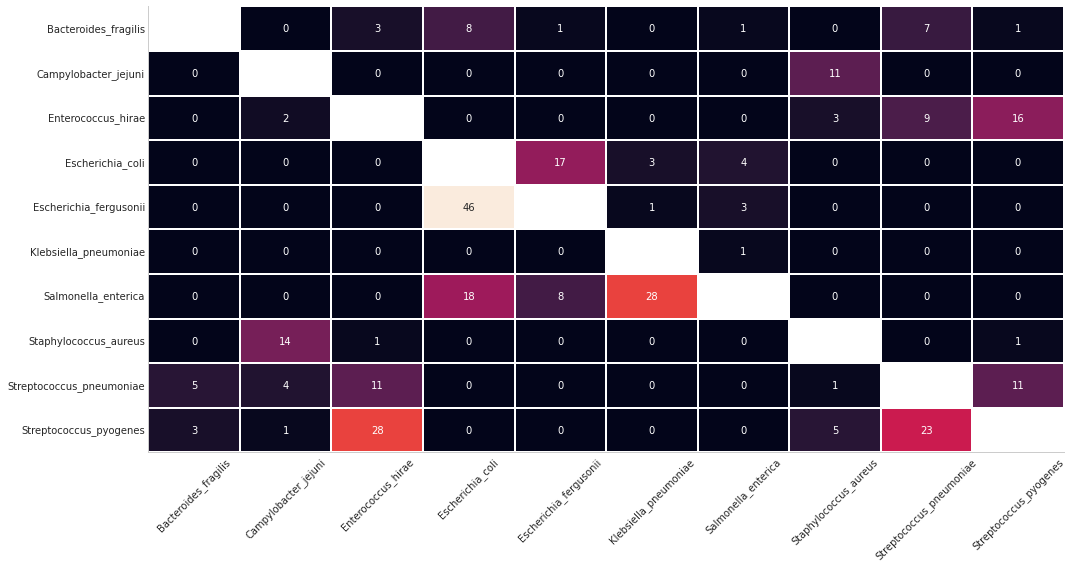

In [61]:
plot_cm_error(confusion_matrix(le.inverse_transform(y_test), oof_y_hat, labels = le.classes_))

# gcd=10000 Train

In [62]:
X_train, y_train, sample_weight_train = get_Xy(X_train_df,gcd=10000) #pseudo_df #gcd_df #df_genome
X_test, y_test, sample_weight_valid = get_Xy(X_test_df,gcd=10000) #pseudo_df #gcd_df #df_genome

# Prepare for multiclass classification
y_train = le.transform(y_train[TARGET_FEATURE_NAME]) # y to categorical
y_test = le.transform(y_test[TARGET_FEATURE_NAME]) # y to categorical

gc.collect()

35929

In [63]:
%%time

preds_valid_f, preds_test = evaluate_model(X_train, y_train, X_test, y_test, sample_weight_train, sample_weight_valid)

0.8864052183597169
0.6570617641772561
CPU times: user 2min 10s, sys: 996 ms, total: 2min 11s
Wall time: 34.5 s


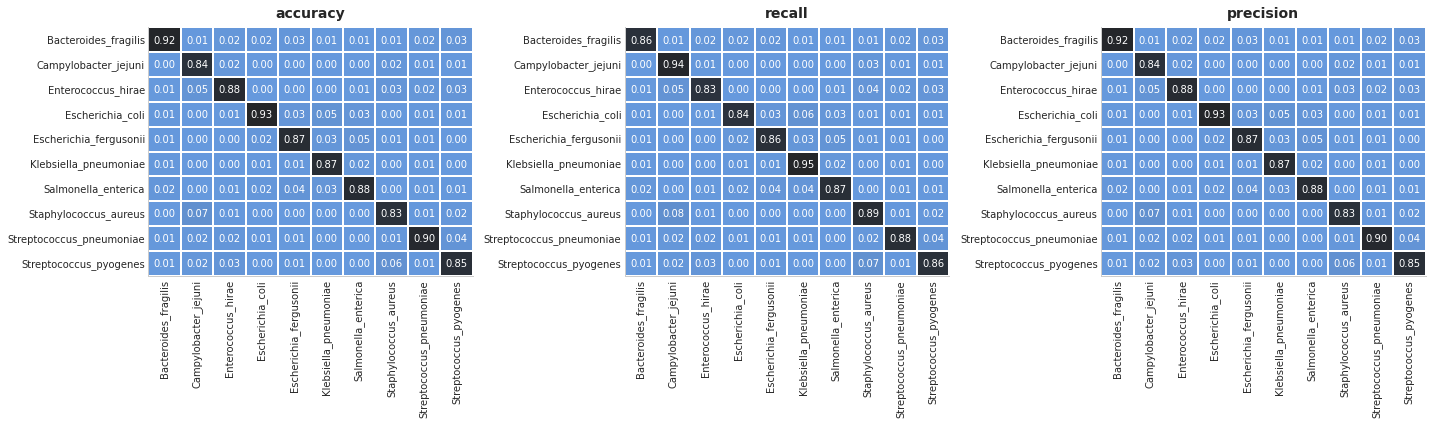

In [64]:
oof_y_hat = []
for key, value in preds_valid_f.items():
    oof_y_hat.append(value)
# create confusion matrix, calculate accuracy,recall & precision
cm = pd.DataFrame(data = confusion_matrix(le.inverse_transform(y_test), oof_y_hat, labels = le.classes_), index = le.classes_, columns = le.classes_)
plot_cm(cm)

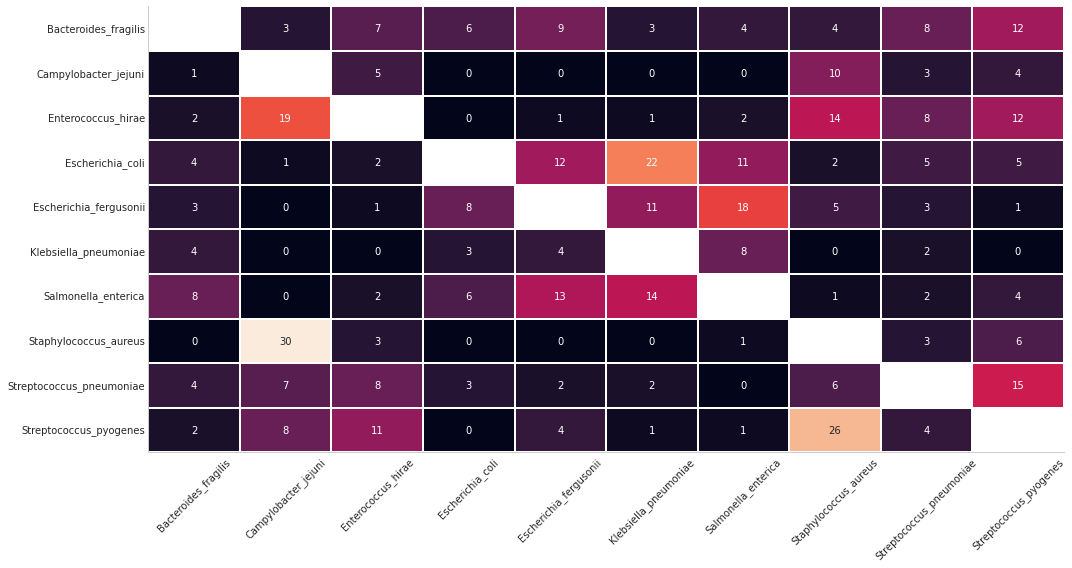

In [65]:
plot_cm_error(confusion_matrix(le.inverse_transform(y_test), oof_y_hat, labels = le.classes_))

## gcd=10000 Genome

In [66]:
train = pd.concat([X_train_df,df_genome])
X_train, y_train, sample_weight_train = get_Xy(train,gcd=10000) #pseudo_df #gcd_df #df_genome
# X_test, y_test, sample_weight_valid = get_Xy(X_test_df,gcd=10000) #pseudo_df #gcd_df #df_genome

# Prepare for multiclass classification
y_train = le.transform(y_train[TARGET_FEATURE_NAME]) # y to categorical
# y_test = le.transform(y_test[TARGET_FEATURE_NAME]) # y to categorical

gc.collect()

35934

In [67]:
%%time

preds_valid_f, preds_test = evaluate_model(X_train, y_train, X_test, y_test, sample_weight_train, sample_weight_valid)

0.8868825073582054
0.6562113135611211
CPU times: user 2min 29s, sys: 1.27 s, total: 2min 30s
Wall time: 39.4 s


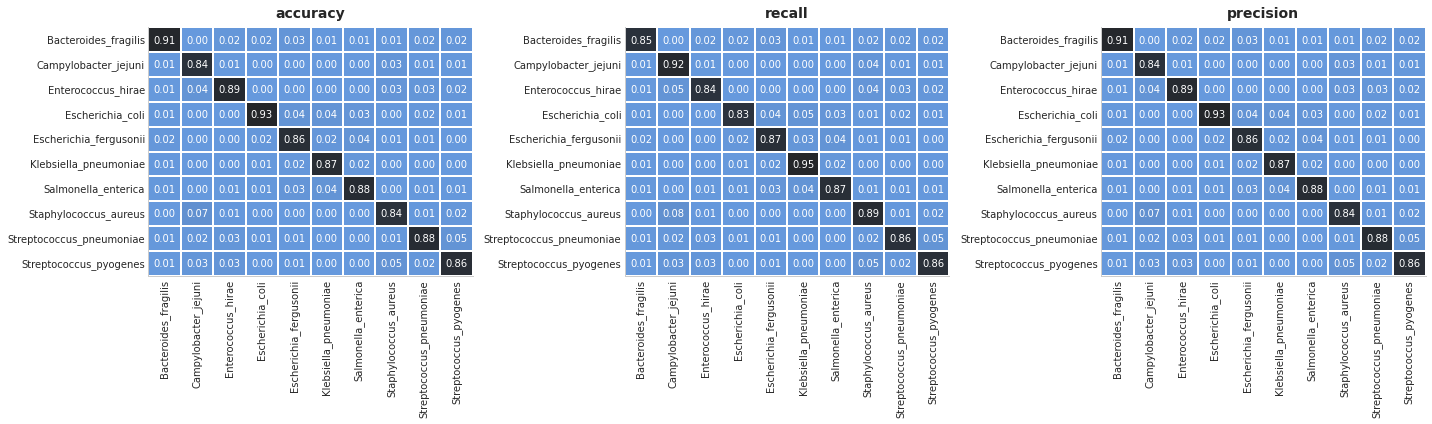

In [68]:
oof_y_hat = []
for key, value in preds_valid_f.items():
    oof_y_hat.append(value)
# create confusion matrix, calculate accuracy,recall & precision
cm = pd.DataFrame(data = confusion_matrix(le.inverse_transform(y_test), oof_y_hat, labels = le.classes_), index = le.classes_, columns = le.classes_)
plot_cm(cm)

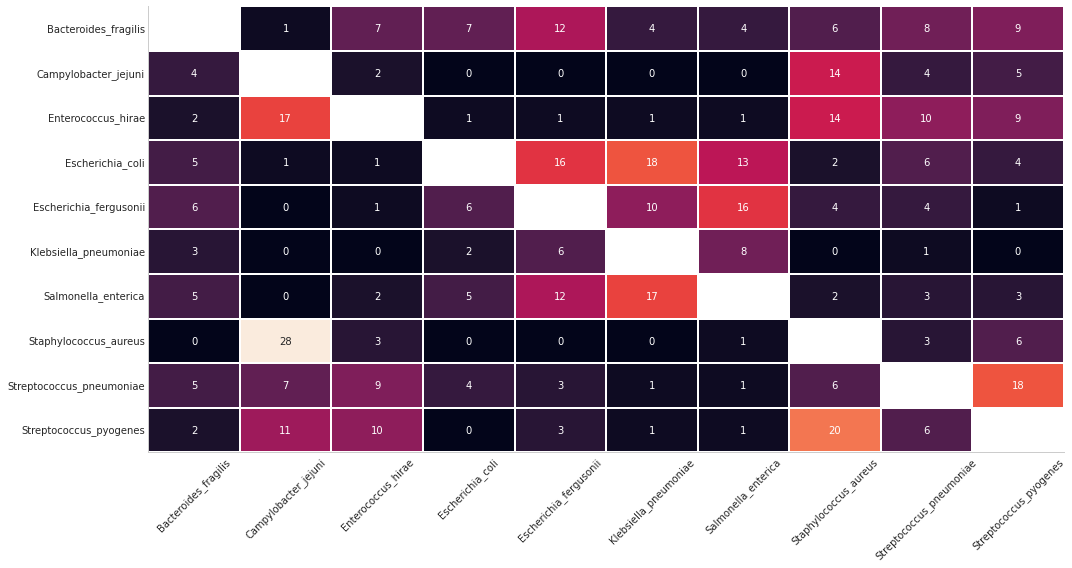

In [69]:
plot_cm_error(confusion_matrix(le.inverse_transform(y_test), oof_y_hat, labels = le.classes_))

In [70]:
y_prob = sum(preds_test) / len(preds_test)

y_pred_tuned = np.argmax(y_prob, axis=1)
y_pred_tuned = le.inverse_transform(y_pred_tuned)
y_prob.shape

(100000, 10)

In [71]:
pd.Series(le.inverse_transform(np.argmax(y_prob, axis=1)), index=X_submission.index).value_counts().sort_index() / len(X_submission) * 100

Bacteroides_fragilis        17.061
Campylobacter_jejuni         9.085
Enterococcus_hirae           5.501
Escherichia_coli            25.382
Escherichia_fergusonii       7.753
Klebsiella_pneumoniae       12.428
Salmonella_enterica          5.952
Staphylococcus_aureus        4.356
Streptococcus_pneumoniae     9.418
Streptococcus_pyogenes       3.064
dtype: float64

# Test GCD=10

In [72]:
X_train, y_train, sample_weight_train = get_Xy(X_train_df,gcd=10) #pseudo_df #gcd_df #df_genome
X_test, y_test, sample_weight_valid = get_Xy(X_test_df,gcd=10) #pseudo_df #gcd_df #df_genome

# Prepare for multiclass classification
y_train = le.transform(y_train[TARGET_FEATURE_NAME]) # y to categorical
y_test = le.transform(y_test[TARGET_FEATURE_NAME]) # y to categorical

gc.collect()

35971

In [73]:
%%time

preds_valid_f, preds_test = evaluate_model(X_train, y_train, X_test, y_test, sample_weight_train, sample_weight_valid)

1.0
0.043624797678615324
CPU times: user 3min 30s, sys: 858 ms, total: 3min 31s
Wall time: 55.5 s


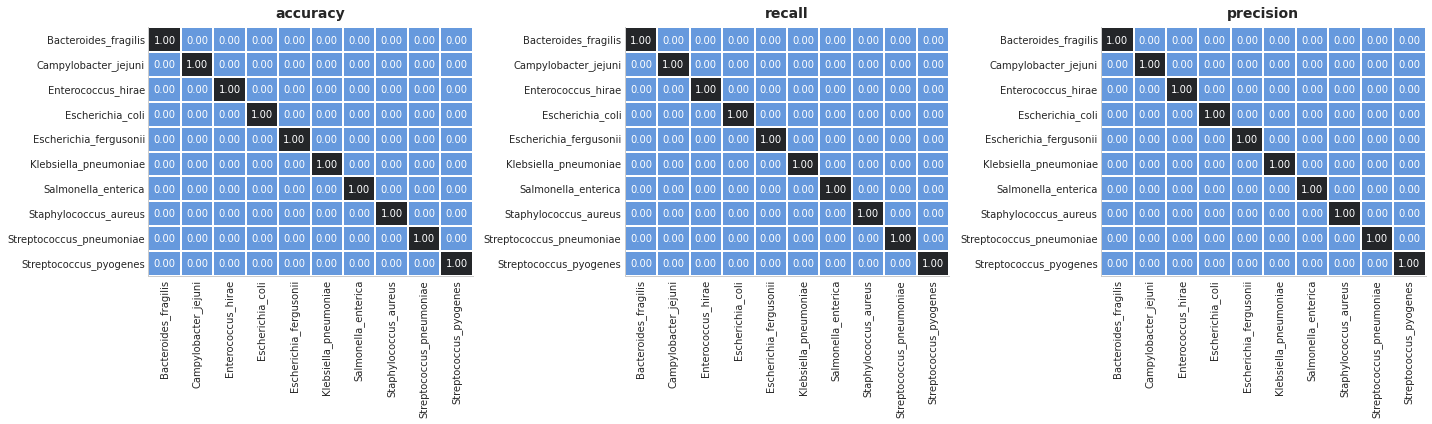

In [74]:
oof_y_hat = []
for key, value in preds_valid_f.items():
    oof_y_hat.append(value)
# create confusion matrix, calculate accuracy,recall & precision
cm = pd.DataFrame(data = confusion_matrix(le.inverse_transform(y_test), oof_y_hat, labels = le.classes_), index = le.classes_, columns = le.classes_)
plot_cm(cm)

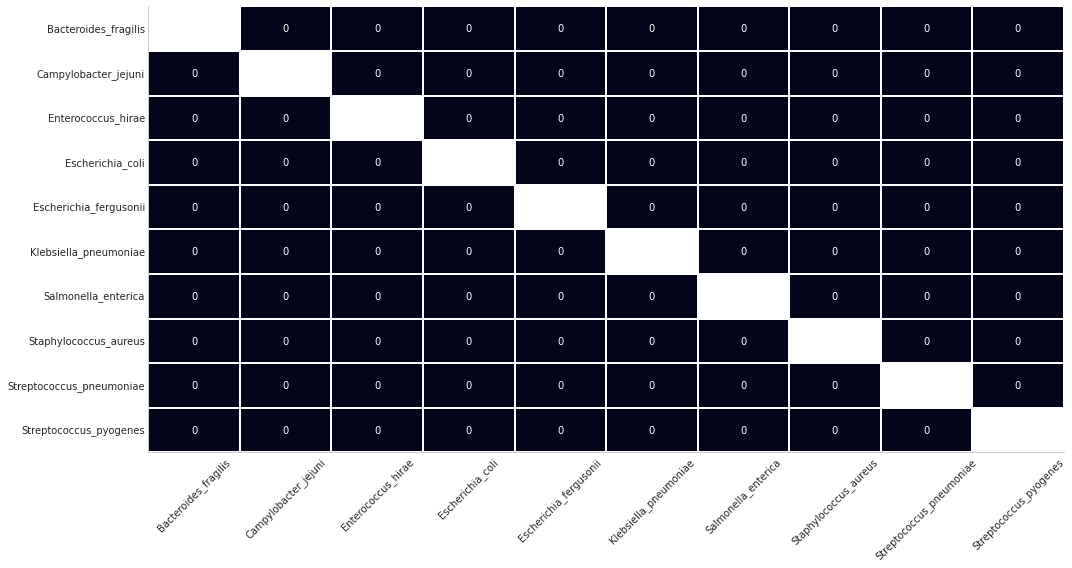

In [75]:
plot_cm_error(confusion_matrix(le.inverse_transform(y_test), oof_y_hat, labels = le.classes_))

# Genome GCD=10

In [76]:
train = pd.concat([X_train_df,df_genome])
X_train, y_train, sample_weight_train = get_Xy(train,gcd=10) #pseudo_df #gcd_df #df_genome

# Prepare for multiclass classification
y_train = le.transform(y_train[TARGET_FEATURE_NAME]) # y to categorical

gc.collect()

35934

1.0
0.04318392048787463
CPU times: user 5min 8s, sys: 1.27 s, total: 5min 9s
Wall time: 1min 20s


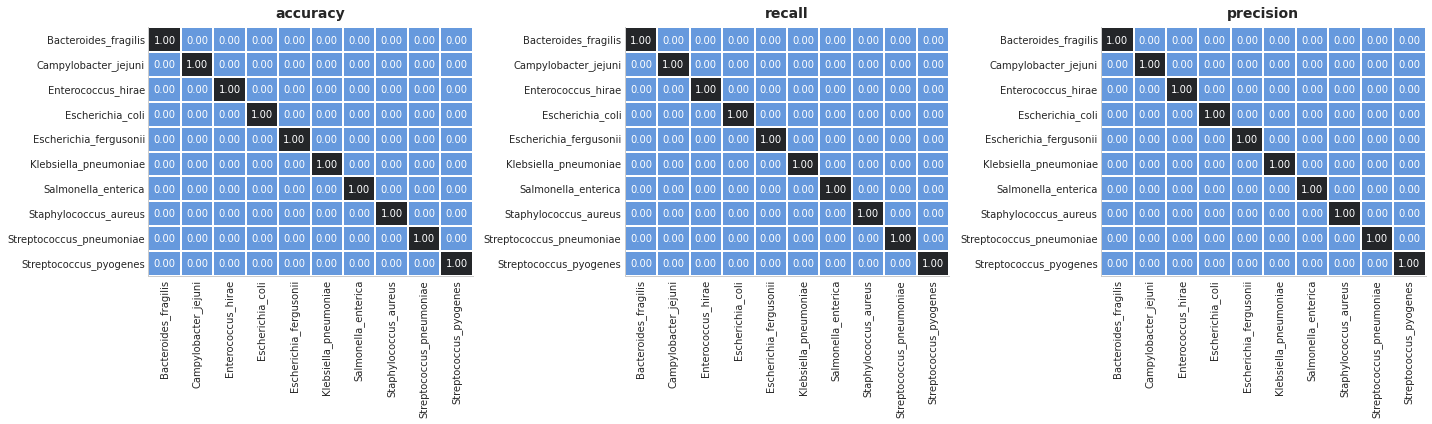

In [77]:
%%time

preds_valid_f, preds_test = evaluate_model(X_train, y_train, X_test, y_test, sample_weight_train, sample_weight_valid)
oof_y_hat = []
for key, value in preds_valid_f.items():
    oof_y_hat.append(value)
# create confusion matrix, calculate accuracy,recall & precision
cm = pd.DataFrame(data = confusion_matrix(le.inverse_transform(y_test), oof_y_hat, labels = le.classes_), index = le.classes_, columns = le.classes_)
plot_cm(cm)

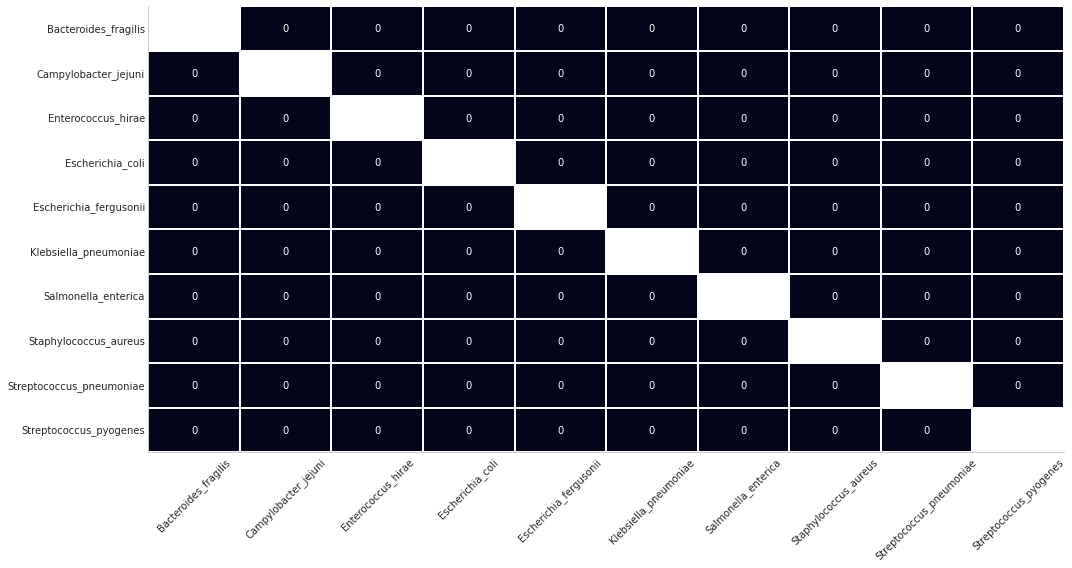

In [78]:
plot_cm_error(confusion_matrix(le.inverse_transform(y_test), oof_y_hat, labels = le.classes_))

# Train GCD=1

In [79]:
X_train, y_train, sample_weight_train = get_Xy(X_train_df,gcd=1) #pseudo_df #gcd_df #df_genome
X_test, y_test, sample_weight_valid = get_Xy(X_test_df,gcd=1) #pseudo_df #gcd_df #df_genome

# Prepare for multiclass classification
y_train = le.transform(y_train[TARGET_FEATURE_NAME]) # y to categorical
y_test = le.transform(y_test[TARGET_FEATURE_NAME]) # y to categorical

gc.collect()

35939

In [80]:
%%time

preds_valid_f, preds_test = evaluate_model(X_train, y_train, X_test, y_test, sample_weight_train, sample_weight_valid)

1.0
0.0009068749498624435
CPU times: user 1min 54s, sys: 723 ms, total: 1min 55s
Wall time: 30.4 s


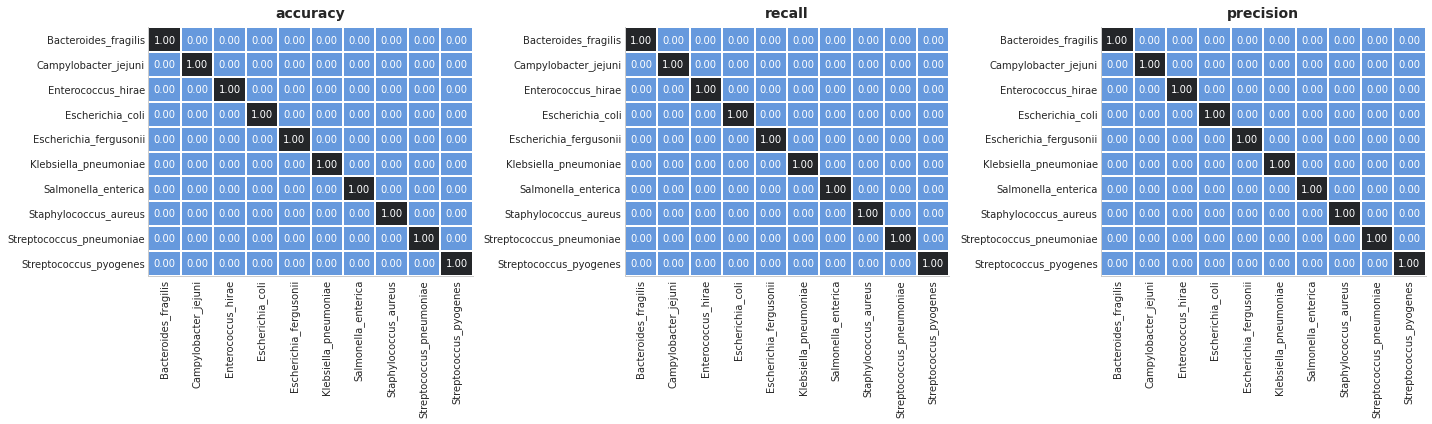

In [81]:
oof_y_hat = []
for key, value in preds_valid_f.items():
    oof_y_hat.append(value)
# create confusion matrix, calculate accuracy,recall & precision
cm = pd.DataFrame(data = confusion_matrix(le.inverse_transform(y_test), oof_y_hat, labels = le.classes_), index = le.classes_, columns = le.classes_)
plot_cm(cm)

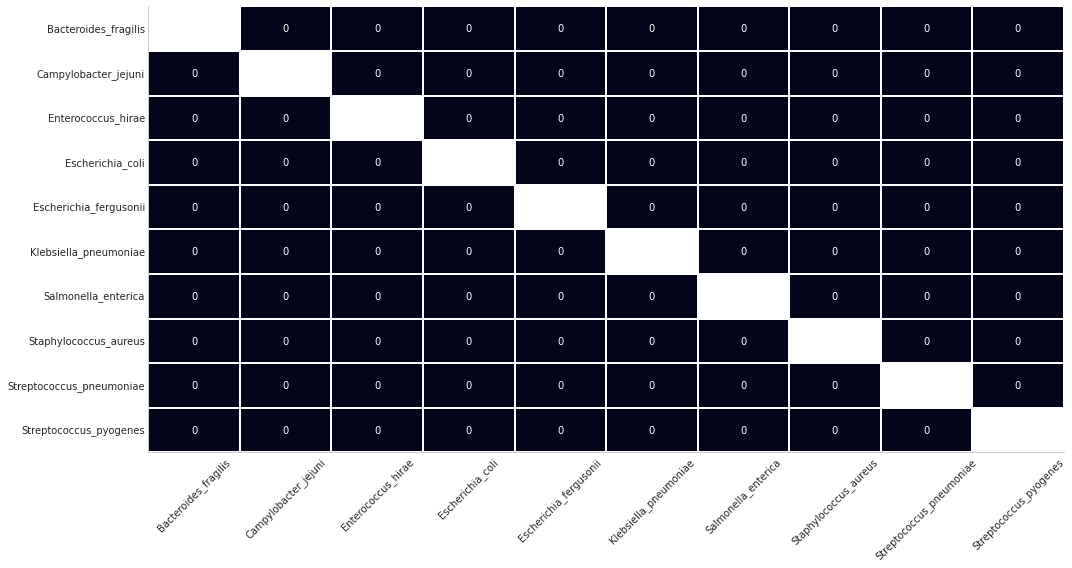

In [82]:
plot_cm_error(confusion_matrix(le.inverse_transform(y_test), oof_y_hat, labels = le.classes_))

# Genome GCD=1

In [83]:
train = pd.concat([X_train_df,df_genome])
X_train, y_train, sample_weight_train = get_Xy(train,gcd=1) #pseudo_df #gcd_df #df_genome

# Prepare for multiclass classification
y_train = le.transform(y_train[TARGET_FEATURE_NAME]) # y to categorical

gc.collect()

35934

1.0
0.0009014079489586572
CPU times: user 2min 37s, sys: 1.13 s, total: 2min 38s
Wall time: 41.7 s


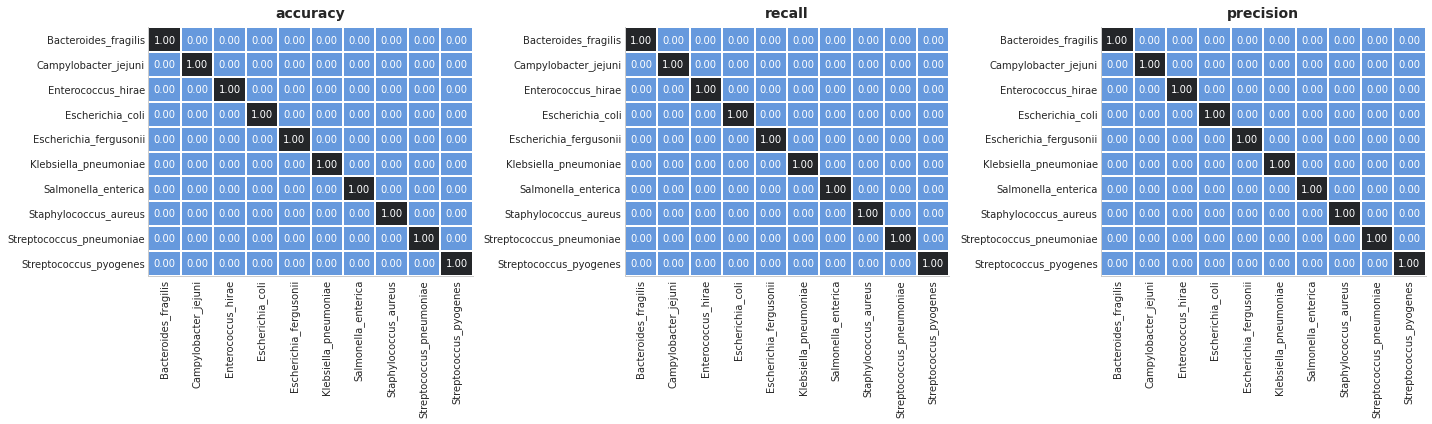

In [84]:
%%time

preds_valid_f, preds_test = evaluate_model(X_train, y_train, X_test, y_test, sample_weight_train, sample_weight_valid)
oof_y_hat = []
for key, value in preds_valid_f.items():
    oof_y_hat.append(value)
# create confusion matrix, calculate accuracy,recall & precision
cm = pd.DataFrame(data = confusion_matrix(le.inverse_transform(y_test), oof_y_hat, labels = le.classes_), index = le.classes_, columns = le.classes_)
plot_cm(cm)

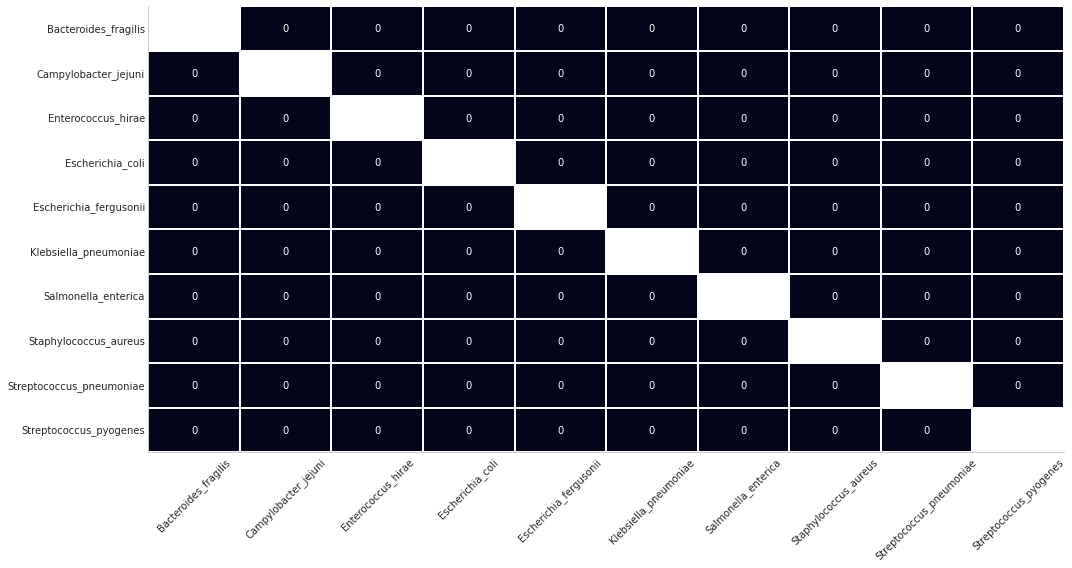

In [85]:
plot_cm_error(confusion_matrix(le.inverse_transform(y_test), oof_y_hat, labels = le.classes_))

# Submission

In [86]:
sub = pd.read_csv(INPUT + '/sample_submission.csv')
sub[TARGET_FEATURE_NAME] = y_pred_tuned

To submit these predictions to the competition, follow these steps:

1. Begin by clicking on the blue **Save Version** button in the top right corner of the window.  This will generate a pop-up window.
2. Ensure that the **Save and Run All** option is selected, and then click on the blue **Save** button.
3. This generates a window in the bottom left corner of the notebook.  After it has finished running, click on the number to the right of the **Save Version** button.  This pulls up a list of versions on the right of the screen.  Click on the ellipsis **(...)** to the right of the most recent version, and select **Open in Viewer**.  This brings you into view mode of the same page. You will need to scroll down to get back to these instructions.
4. Click on the **Output** tab on the right of the screen.  Then, click on the file you would like to submit, and click on the blue **Submit** button to submit your results to the leaderboard.

You have now successfully submitted to the competition!

# Next Steps #

If you want to keep working to improve your performance, select the blue **Edit** button in the top right of the screen. Then you can change your code and repeat the process. There's a lot of room to improve, and you will climb up the leaderboard as you work.

Be sure to check out [other users' notebooks](https://www.kaggle.com/c/tabular-playground-series-feb-2022/code) in this competition. You'll find lots of great ideas for new features and as well as other ways to discover more things about the dataset or make better predictions. There's also the [discussion forum](https://www.kaggle.com/c/tabular-playground-series-feb-2022/discussion), where you can share ideas with other Kagglers.

Have fun Kaggling!